In [3]:
!pip install SimpleITK pyradiomics neuroCombat MLstatkit

In [4]:
from __future__ import print_function
import logging
import pandas
import SimpleITK as sitk
import radiomics
import re
import pickle
import math
from radiomics import featureextractor
from neuroCombat import neuroCombat
import sys, os
import numpy as np
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import auc
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import linear_model
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
import shutil
from scipy import stats
import datetime
import matplotlib.pyplot as plt
from MLstatkit.stats import Delong_test as delong
#import delong.delong as delong
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import mannwhitneyu
%matplotlib inline



In [ ]:
#run properly first to check, then add delongs, then check for segs of difficult cases and add as 4th dataset
#for difficult cases treat as fourth set to see what maintains performance
#add way of saving individual diagnosis? one big spread sheet


In [ ]:
# back up incase grid search doesnt work

In [7]:
home="/Users/mnlmd/Documents/PyradiomicsResults/"

if not os.path.exists(home):
  os.makedirs(home)
else:
  pass
if not os.path.exists(os.path.join(home,"Template")):
  os.makedirs(os.path.join(home,"Template"))
else:
  pass
temp=os.path.join(home,"Template")
Date_folder = datetime.datetime.today().strftime ('%Y%m%d')
Datetime_folder = datetime.datetime.today().strftime ('%Y%m%d-%H%M%S')
path=os.path.join(home,Date_folder, Datetime_folder)
shutil.copytree(temp,path)


'/Users/mnlmd/Documents/PyradiomicsResults/20250201/20250201-183149'

In [8]:
import nbconvert

In [10]:
%%bash

jupyter nbconvert --to html pipeline_step3_test_parmssearch.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'pipeline_step3_test_parmssearch.ipynb' matched no files


CalledProcessError: Command 'b'\njupyter nbconvert --to html pipeline_step3_test_parmssearch.ipynb\n'' returned non-zero exit status 255.

In [9]:
d_path= path

dest=os.path.join(d_path,str(Date_folder)+"start_pipeline_step3_test_parmssearch.html")
home="/Users/mnlmd/Documents/PyradiomicsResults/"

temp=os.path.join(home,"Template_cpu")
source = os.path.join(temp,"pipeline_step3_test_parmssearch.html")
shutil.move(source, dest)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mnlmd/Documents/PyradiomicsResults/Template_cpu/pipeline_step3_test_parmssearch.html'

In [ ]:
# fix these when training finished


In [ ]:
icsv=pandas.read_csv("/Users/mnlmd/Documents/pyradinputnov22_3.csv")

y=icsv.iloc[1,0]
imtest=sitk.ReadImage(y)

In [ ]:
print(y)
print(imtest.GetOrigin())

In [ ]:
def main():
    outPath = path
#     change to path_output from pipeline step 2, could change 2020_05_09 to an input cmd variable and add it to file names below

    inputCSV = "/Users/mnlmd/Documents/pyradinputnov22_3.csv"
    outputFilepath = os.path.join(outPath, 'radiomics_features_pd_' +str(Date_folder)+'.csv')
    progress_filename = os.path.join(outPath, 'pyrad_log.txt')
    params = os.path.join(outPath, 'Params.yaml')

  # Configure logging
    rLogger = logging.getLogger('radiomics')

  # Set logging level
  # rLogger.setLevel(logging.INFO)  # Not needed, default log level of logger is INFO

  # Create handler for writing to log file
    handler = logging.FileHandler(filename=progress_filename, mode='w')
    handler.setFormatter(logging.Formatter('%(levelname)s:%(name)s: %(message)s'))
    rLogger.addHandler(handler)

  # Initialize logging for batch log messages
    logger = rLogger.getChild('batch')

  # Set verbosity level for output to stderr (default level = WARNING)
    radiomics.setVerbosity(logging.INFO)

    logger.info('pyradiomics version: %s', radiomics.__version__)
    logger.info('Loading CSV')

  # ####### Up to this point, this script is equal to the 'regular' batchprocessing script ########

    try:
    # Use pandas to read and transpose ('.T') the input data
    # The transposition is needed so that each column represents one test case. This is easier for iteration over
    # the input cases
        flists = pandas.read_csv(inputCSV).T
    except Exception:
        logger.error('CSV READ FAILED', exc_info=True)
        exit(-1)

    logger.info('Loading Done')
    logger.info('Patients: %d', len(flists.columns))

    if os.path.isfile(params):
        extractor = featureextractor.RadiomicsFeatureExtractor(params)
    else:  # Parameter file not found, use hardcoded settings instead
        settings = {}
        settings['binWidth'] = 0.075
        settings['resampledPixelSpacing'] = [4,4,4]
        settings['interpolator'] = sitk.sitkBSpline
        settings['enableCExtensions'] = True

        extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    # extractor.enableInputImages(wavelet= {'level': 2})

    logger.info('Enabled input images types: %s', extractor.enabledImagetypes)
    logger.info('Enabled features: %s', extractor.enabledFeatures)
    logger.info('Current settings: %s', extractor.settings)

  # Instantiate a pandas data frame to hold the results of all patients
    results = pandas.DataFrame()

    for entry in flists:  # Loop over all columns (i.e. the test cases)
        logger.info("(%d/%d) Processing Patient (Image: %s, Mask: %s)",
                    entry + 1,
                    len(flists),
                    flists[entry]['Image'],
                    flists[entry]['Mask'])

        imageFilepath = flists[entry]['Image']
        maskFilepath = flists[entry]['Mask']
        label = flists[entry].get('Label', None)

        if str(label).isdigit():
            label = int(label)
        else:
            label = None

        if (imageFilepath is not None) and (maskFilepath is not None):
            featureVector = flists[entry]  # This is a pandas Series
            featureVector['Image'] = os.path.basename(imageFilepath)
            featureVector['Mask'] = os.path.basename(maskFilepath)

            try:
        # PyRadiomics returns the result as an ordered dictionary, which can be easily converted to a pandas Series
        # The keys in the dictionary will be used as the index (labels for the rows), with the values of the features
        # as the values in the rows.
                result = pandas.Series(extractor.execute(imageFilepath, maskFilepath, label))
                featureVector = featureVector.append(result)
            except Exception:
                logger.error('FEATURE EXTRACTION FAILED:', exc_info=True)

      # To add the calculated features for this case to our data frame, the series must have a name (which will be the
      # name of the column.http://localhost:8888/notebooks/Documents/PyradiomicsResults/Template_cpu/pipeline_step3_test.ipynb#
            featureVector.name = entry
      # By specifying an 'outer' join, all calculated features are added to the data frame, including those not
      # calculated for previous cases. This also ensures we don't end up with an empty frame, as for the first patient
      # it is 'joined' with the empty data frame.
            results = results.join(featureVector, how='outer')  # If feature extraction failed, results will be all NaN

    logger.info('Extraction complete, writing CSV')
    # .T transposes the data frame, so that each line will represent one patient, with the extracted features as columns
    results.T.to_csv(outputFilepath, index=False, na_rep='NaN')
    logger.info('CSV writing complete')


if __name__ == '__main__':
    main()

In [ ]:

inputsheet = pandas.read_excel("/Users/mnlmd/Documents/Images/Image_info/allinfo_newinput_22.xlsx")
LRparams=pandas.read_excel("/Users/mnlmd/Documents/PyradiomicsResults/Key_results/20210115-010554_indfeat/Harmonised/Baseline/Results/LGR_ind_features_gs.xlsx")
PCAparams=pandas.read_excel("/Users/mnlmd/Documents/PyradiomicsResults/Key_results/20210127-145609_gridsearch/Feature_Selection/Harmonised/Baseline/Results/pcaHarm_BLclassifier_performance.xlsx")
faparams=pandas.read_excel("/Users/mnlmd/Documents/PyradiomicsResults/Key_results/20210127-145609_gridsearch/Harmonised/Baseline/Results/feat_3permetHarm_BL_MLperformance_feature_reduction.xlsx")
fbparams=pandas.read_excel("/Users/mnlmd/Documents/PyradiomicsResults/Key_results/20210127-145609_gridsearch/Feature_Selection/Baseline/Results/feat_sel_corrHarm_BL_MLperformance_feature_reduction.xlsx")

In [ ]:
import pandas as pd

In [ ]:
outputFile= os.path.join(path, 'radiomics_features_pd_' +str(Date_folder)+'.csv')
pyrad_output=pd.read_csv(outputFile)
print(len(pyrad_output))

In [ ]:


# pyrad_output=pyrad_output.dropna(axis=0, how='any')
pyrad_output=pyrad_output.reset_index()

print(len(pyrad_output))


In [ ]:
pyrad_output

In [ ]:
# inputsheet_suvx=pd.read_csv("/Users/mnlmd/Documents/Input/pyradinput20210927.csv")
# SUVx is the mean of the voxels that are equal or greater than x% of SUV max in the region of interest
SUV50=[]
SUV60=[]
SUV70=[]
SUV80=[]
SUV90=[]
for i, row in pyrad_output.iterrows():
    try:
        print(i)
        PETname=row["Image"]
        fol=PETname.split("_")[1]
        fol2=PETname.split("_")[0]
        PETpath1='/Users/mnlmd/Documents/Input/'+fol+'/'+PETname
        maskpath1=os.path.join('/Users/mnlmd/Documents/Outputs/3D/',row["Mask"])
        PETpath2='/Users/mnlmd/Documents/OneDriveUMCG/Input/'+fol2+'/'+PETname
        maskpath2=os.path.join('/Volumes/TOSHIBA_EXT/Outputs/3D/',row["Mask"])
        PETpath3='/Users/mnlmd/Desktop/Gijs/Input/'+fol+'/'+PETname
        maskpath3=os.path.join('/Users/mnlmd/Desktop/Gijs/Outputs/3D/',row["Mask"])

        PETpath=None
        maskpath=None

        print(maskpath1)
        if os.path.isfile(PETpath1):

            PETpath = PETpath1
        elif os.path.isfile(PETpath2):


            PETpath = PETpath2
        elif os.path.isfile(PETpath3):
            PETpath = PETpath3
        else:
            print('fail')


        if os.path.isfile(maskpath1):
            maskpath = maskpath1
        elif os.path.isfile(maskpath2):
                maskpath = maskpath2
        elif os.path.isfile(maskpath3):
                maskpath = maskpath3
        else:
            print('fail')


        print(PETpath, maskpath)

        imagePET = sitk.ReadImage(PETpath)
        mask = sitk.ReadImage(maskpath)
        PETarray=sitk.GetArrayFromImage(imagePET)

        maskarray=sitk.GetArrayFromImage(mask)



        try:
    #     only values in whole aorta ROI
            PETarray2=np.where(maskarray>0, PETarray,0)

            PETarray_val = PETarray2[PETarray2 != 0]


            try:
                suvmax=PETarray_val.max()
            except:
                suvmax=0

            suvmax50=0.5*suvmax
            suvmax60=0.6*suvmax
            suvmax70=0.7*suvmax
            suvmax80=0.8*suvmax
            suvmax90=0.9*suvmax

            PETarray_50 = PETarray_val[PETarray_val >= suvmax50]
            PETarray_60 = PETarray_val[PETarray_val >= suvmax60]
            PETarray_70 = PETarray_val[PETarray_val >= suvmax70]
            PETarray_80 = PETarray_val[PETarray_val >= suvmax80]
            PETarray_90 = PETarray_val[PETarray_val >= suvmax90]


            try:
                suv50 = sum(PETarray_50) / len(PETarray_50)
                suv60 = sum(PETarray_60) / len(PETarray_60)
                suv70 = sum(PETarray_70) / len(PETarray_70)
                suv80 = sum(PETarray_80) / len(PETarray_80)
                suv90 = sum(PETarray_90) / len(PETarray_90)
            except:
                suv50 = 0
                suv60 = 0
                suv70 = 0
                suv80 = 0
                suv90 = 0
        except:
            suv50 = 0
            suv60 = 0
            suv70 = 0
            suv80 = 0
            suv90 = 0

    except:

        suv50 = 0
        suv60 = 0
        suv70 = 0
        suv80 = 0
        suv90 = 0

    SUV50.append(suv50)
    SUV60.append(suv60)
    SUV70.append(suv70)
    SUV80.append(suv80)
    SUV90.append(suv90)
    print(PETname, suv50, suv90)






pyrad_output['SUV 50'] = SUV50
pyrad_output['SUV 60'] = SUV60
pyrad_output['SUV 70'] = SUV70
pyrad_output['SUV 80'] = SUV80
pyrad_output['SUV 90'] = SUV90

In [ ]:
pyrad_output


In [ ]:
pyrad_output=pyrad_output.reset_index()

In [ ]:
Add_=pd.DataFrame( columns=inputsheet.columns)

In [ ]:
inputsheet

In [ ]:
row_= pd.Series([np.nan] * 8)
print(row_)

In [ ]:
for i, row in pyrad_output.iterrows():
    image=row["Image"]
    x=0
    for i, row in inputsheet.iterrows():
        patient=row["Patient"]
        date=str(row["Date"])


        if patient in image:
            if date in image or date=='dateunknown':
                    Add_=Add_.append(row,ignore_index=True)
                    x=1
                    print(len(Add_))
        else:
            pass


    if x==0:
        row_= pd.Series([np.nan] * len(row))

        Add_=Add_.append(row_,ignore_index=True)

print(len(Add_))
# if len(Add_) != len(pyrad_output):
#     sys.exit('Adding patient info failed - lengths not equal')

In [ ]:
Add_

In [ ]:
Add_1=Add_.loc[:,'Patient':'Scanner']
# Add_2=Add_.loc[:,'SUV 50':'Grade Ground Truth']

In [ ]:
path_harm=os.path.join(path, "Harmonised")
path_org=os.path.join(path, "Original")

In [ ]:
Add_1

In [ ]:
pyrad_output=pd.concat([pyrad_output,Add_1],axis=1)
# pyrad_output=pd.concat([pyrad_output,Add_1],axis=1)
print(len(pyrad_output))

In [ ]:
# pyrad_output["Patient.1"]
pyrad_output

In [ ]:
# np.where(pyrad_output["Patient.1"]=="LVV42_")

In [ ]:
# pyrad_output.at[70,"Diagnosis"]=0

In [ ]:
df_data= pd.DataFrame(columns= ["Param", "Value"])


In [ ]:



# Grade=[]
# for i, row in pyrad_output.iterrows():


#     liverSUVmean=row["Liver SUVmean"]

#     try:
#         liverSUVmean=float(liverSUVmean)

#     except:
#         liverSUVmean = liverSUVmean.replace('--', '0')
#         liverSUVmean=float(liverSUVmean)

#     Suv50=float(row["original_firstorder_90Percentile"])
#     bpsuvmean=float(row["Blood Pool SUV Mean"])

#     if Suv50<=bpsuvmean:
#         grade=0

#     elif Suv50<(0.95*liverSUVmean) and Suv50>bpsuvmean:
#         grade=1

#     elif Suv50>=(0.95*liverSUVmean) and Suv50<=(1.05*liverSUVmean):
#         grade=2

#     elif Suv50>(1.05*liverSUVmean):
#         grade=3



#     Grade.append(grade)

# print(len(Grade),len(pyrad_output))
# if len(Grade) != len(pyrad_output):
#     sys.exit('Grading failed - lengths not equal')


# pyrad_output['Grade Manual'] = Grade

# change to grade only method soon


In [ ]:
import pandas as pd

In [ ]:
pyrad_output.rename(columns = {'Patient.1':'Patient'}, inplace = True)

In [ ]:
pyrad_output.to_excel(os.path.join(path,"pyrad_output_complete.xlsx"))


In [ ]:
# pyrad_output=pd.read_excel("/Users/mnlmd/Documents/PyradiomicsResults/20221117/20221117-161006/pyrad_output_complete.xlsx")

In [ ]:
pyrad_output=pd.read_excel("/Users/mnlmd/Documents/PyradiomicsResults/20221222/20221222-213019/pyrad_output_complete_2.xlsx")

In [ ]:
# pyrad_output=pd.read_excel(os.path.join(path,"pyrad_output_complete.xlsx"))

In [ ]:
pyrad_output

In [ ]:

Harm=pyrad_output


Harm_ = Harm.loc[:,"original_shape_Elongation":"SUV 90"]
print(Harm_.isnull().values.any())
print(Harm.shape)
print(Harm_.shape)


# std_scaler = StandardScaler()

# Harm_2= std_scaler.fit_transform(Harm_.to_numpy())
# Harm_2= pd.DataFrame(Harm_2,columns=Harm_.columns)
# Harm_=Harm_2

# print("Scaled Dataset Using StandardScaler")
# print(Harm_.head())


Harm_diags = Harm.loc[:,"Image":"diagnostics_Versions_SimpleITK"]
Harm_.set_index(Harm['Patient'])
Harm_app= Harm.loc[:,"Patient"  :]
print(Harm_app.shape)
Harm_app.set_index(Harm["Patient"])
batch_col = 'Scanner'

# data=np.transpose(Harm_)

# covars=pd.DataFrame(Harm['Patient'])

data_combat = neuroCombat(data=Harm_,
                          covars=Harm_app,
                          batch_col=batch_col)

print((data_combat))
Harmonised = pd.DataFrame(data_combat)
print(Harmonised)
# Harmonised=np.transpose(HarmonisedT)

Harmonised=Harmonised.set_index(Harm['Patient'])
Harm_app=Harm_app.set_index(Harm["Patient"])
Harm_diags=Harm_diags.set_index(Harm["Patient"])
Harmonised.columns = Harm_.columns

Harmonised=pd.concat([Harmonised, Harm_app], axis=1)
Harmonised=pd.concat([Harm_diags, Harmonised], axis=1)
Harmonised.to_excel(os.path.join(path_harm,"Harmonised.xlsx"))

In [ ]:
# from pycombat import Combat
# Harm=pyrad_output


# Harm_ = Harm.loc[:,"original_shape_Elongation":"SUV 90"]
# # print(Harm_.isnull().values.any())
# print(Harm.shape)
# print(Harm_.shape)

In [ ]:
# Harm


In [ ]:
# Harm_

In [ ]:
# Harm['Scanner']

In [ ]:
# combat = Combat()
# # df.reset_index()
# Harm_diags = Harm.loc[:,"Image":"diagnostics_Versions_SimpleITK"]
# Harm_=Harm_.set_index(Harm['Patient'])
# Harm=Harm.set_index(Harm['Patient'])
# Harm_app= Harm.loc[:,"Patient"  :]
# # print(Harm_app.shape)
# Harm_app.set_index(Harm["Patient"])


# data=np.transpose(Harm_)

# # covars=pd.DataFrame(Harm['Patient'])

# b=Harm['Scanner']

# print(b)
# print(data.shape, Harm_.shape)
# print(Harm['Scanner'].shape)
# # combat.fit(Y=Harm_, b=b)
# Harmonised = combat.fit_transform(Y=Harm_, b=b)

In [ ]:
# data_combat = neuroCombat(dat=data,
#                           covars=Harm_app,
# #                           batch_col=batch_col)


# # HarmonisedT = pd.DataFrame(data=data_combat)
# # print(HarmonisedT)


# Harmonised=Harmonised.set_index(Harm['Patient'])
# Harm_app=Harm_app.set_index(Harm["Patient"])
# Harm_diags=Harm_diags.set_index(Harm["Patient"])
# Harmonised.columns = Harm_.columns

# Harmonised=pd.concat([Harmonised, Harm_app], axis=1)
# Harmonised=pd.concat([Harm_diags, Harmonised], axis=1)
# Harmonised.to_excel(os.path.join(path_harm,"Harmonised.xlsx"))

In [ ]:
# Harmonised=pyrad_output2.loc[:,"Image":"Scanner"]
pyrad_output=pyrad_output.loc[:,"Image":"Scanner"]

In [ ]:
# refining full set, org and harm will be passed through
dataframes=[Harmonised, pyrad_output]

Harmonised.name = 'Harmonised'

pyrad_output.name = 'pyrad_output'


for df in dataframes:

    df['Diagnosis'] = df['Diagnosis'].astype(float)
    df['Control Type'] = df['Control Type'].astype(float)
    df['Category'] = df['Category'].astype(float)


    df['Dataset'] = df['Dataset'].astype(float)



In [ ]:
radfeat= pyrad_output.loc[:,"original_shape_Elongation":"SUV 90"]
Feature= radfeat.columns.values



Feature = [f.replace('original_', '') for f in Feature]
Feature = [f.replace('_', ' ') for f in Feature]
Feature = [f.replace('gldm', 'GLDM') for f in Feature]
Feature = [f.replace('glrlm', 'GLRLM') for f in Feature]
Feature = [f.replace('glszm', 'GLSZM') for f in Feature]
Feature = [f.replace('glcm', 'GLCM') for f in Feature]
Feature = [f.replace('ngtdm', 'NGTDM') for f in Feature]
x=pd.Series(Feature)
print(Feature)
print(type(x))
f = open(os.path.join(path,"features.txt"), "a")
print(x.to_latex(index=False), file=f)
f.close()


In [ ]:
for df in dataframes:

    a=[float(3.0),float(2.0)]
    b=[float(0.0),float(1.0),float(2.0)]


    full=df
    BL = full

    GCA = BL[BL['Category'].isin(b)]

    if "Harm" in df.name:
        outputpath=path_harm
    if "_" in df.name:
        outputpath=path_org


    full.to_excel(os.path.join(outputpath,"pyrad_full.xlsx"))
    BL.to_excel(os.path.join(outputpath,"Baseline","pyrad_BL.xlsx"))
    GCA.to_excel(os.path.join(outputpath,"GCA","pyrad_GCA.xlsx"))
    print(df.name)
    if "Harm" in df.name:
        Harm_BL=BL
        Harm_GCA=GCA
    if "_" in df.name:
        Org_BL=BL
        Org_GCA=GCA


In [ ]:
print(np.shape(Harmonised))

In [ ]:
Org_GCA


In [ ]:
Org_BL=Org_BL.set_index(Org_BL["Patient"])
Org_GCA=Org_GCA.set_index(Org_GCA["Patient"])

dfs=[Harm_GCA,Org_GCA]

# dfs=[Harm_GCA,Harm_BL,Org_BL,Org_GCA]
Harm_BL.name="Harm_BL"
Harm_GCA.name="Harm_GCA"
Org_BL.name="Org_BL"
Org_GCA.name="Org_GCA"
dfs_harm=[Harm_BL, Harm_GCA]
dfs_org=[Org_BL, Org_GCA]

plt.rcParams.update({'font.size': 18})

plt.rc('legend', fontsize=10)    # legend fontsize


In [ ]:
# def popdis(df_bl,path_type):

#     plt.rc('legend', fontsize=18)
#     y_BL=df_bl['Subtypes Broad'].astype(str)
#     x_BL=df_bl['Diagnosis'].astype(str)
#     count_GCA=y_BL.value_counts()
#     count_LVV=x_BL.value_counts()

#     LVV=count_LVV.loc["1.0"]
#     gca=count_GCA.loc["1.0"]
#     control_gca=count_GCA.loc["0.0"]
#     control_lvv=count_LVV.loc["0.0"]
#     TAK=count_GCA.loc["2.0"]
#     misc=count_GCA.loc["4.0"]
#     unsp=count_GCA.loc["3.0"]

#     print(" LVV:" +str(LVV)," GCA:" +str(gca)," Control gca:" +str(control_gca)," Control lvv:" +str(control_lvv)," TAK:" +str(TAK)," Misc:" +str(misc)," unsp:" +str(misc))




#     labels = 'GCA', 'TAK', 'Miscellaneous', 'Unspecified LVV', 'Control'
#     sizes = [ int(gca), int(TAK), int(misc), int(unsp), int(control_lvv)]
#     x = np.char.array([ 'GCA', 'TAK', 'Miscellaneous', 'Unspecified LVV', 'Control'])
#     y = np.array(sizes)
#     colors=['indigo','mediumpurple', 'darkviolet','thistle','slateblue',]  # 'indigo', 'darkviolet','medium purple','darkmagenta','slateblue','thistle'

#     porcent = 100.*y/y.sum()

#     patches, texts = plt.pie(y, colors=colors, startangle=90, radius=2)
#     labels = ['{0} - {1:1.2f} %  - {2}'.format(i,j,k) for i,j,k in zip(x, porcent,y)]

#     sort_legend = True
#     if sort_legend:
#         patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
#                                               key=lambda x: x[2],
#                                               reverse=True))

#     plt.legend(patches,  labels, loc = 3, bbox_to_anchor=(2, 0))
#     fname=os.path.join(path_type,"Cat_Pop_Dis.jpg")
#     plt.tight_layout()
#     plt.savefig(fname, bbox_inches = "tight", dpi=300,quality=95)
#     plt.clf()



#     sizes = [ int(LVV), int(control_lvv)]
#     x = np.char.array([ 'LVV', 'Control'])
#     y = np.array(sizes)
#     colors=['indigo','thistle',]  # 'indigo', 'darkviolet','medium purple','darkmagenta','slateblue','thistle'

#     porcent = 100.*y/y.sum()

#     patches, texts = plt.pie(y, colors=colors, startangle=90, radius=2)
#     labels = ['{0} - {1:1.2f} %  - {2}'.format(i,j,k) for i,j,k in zip(x, porcent,y)]

#     sort_legend = True
#     if sort_legend:
#         patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
#                                               key=lambda x: x[2],
#                                               reverse=True))

#     plt.legend(patches,  labels, loc = 2, bbox_to_anchor=(2, 0))

#     fname=os.path.join(path_type,"Baseline","Figures","BL_Pop_Dis.jpg")
#     plt.tight_layout()
#     plt.savefig(fname, bbox_inches = "tight", dpi=300,quality=95)
#     plt.clf()




#     sizes = [ int(gca), int(control_lvv)]
#     x = np.char.array([ 'GCA', 'Control'])
#     y = np.array(sizes)
#     colors=['indigo','thistle',]  # 'indigo', 'darkviolet','medium purple','darkmagenta','slateblue','thistle'

#     porcent = 100.*y/y.sum()

#     patches, texts = plt.pie(y, colors=colors, startangle=90, radius=2)
#     labels = ['{0} - {1:1.2f} %  - {2}'.format(i,j,k) for i,j,k in zip(x, porcent,y)]

#     sort_legend = True
#     if sort_legend:
#         patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
#                                               key=lambda x: x[2],
#                                               reverse=True))

#     plt.legend(patches,  labels, loc = 2, bbox_to_anchor=(2, 0))

#     fname=os.path.join(path_type,"GCA", "Figures","GCA_Pop_Dis.jpg")
#     plt.tight_layout()
#     plt.savefig(fname, bbox_inches = "tight", dpi=300,quality=95)
#     plt.clf()
#     return(LVV, gca, control_lvv, TAK, misc, unsp)

In [ ]:
# popdis(Harm_BL,path_harm)

# popdis(Org_BL,path_org)

# plt.rc('legend', fontsize=10)

In [ ]:

# for dataframe in dfs:
#     if "Harm" in dataframe.name:

#         path_type = path_harm
#     if "Org" in dataframe.name:
#         path_type = path_org
#     if "BL" in dataframe.name:

#         folder = "Baseline"
#     if "GCA" in dataframe.name:
#         folder = "GCA"
#     x_grades=dataframe['Grade Manual'].astype(str)
#     count_Grades=x_grades.value_counts()

#     print(count_Grades)



#     df_grad= pd.DataFrame(columns= ["Grade", "No. of Patients with Grade"])
#     try:
#         df_grad=df_grad.append ({"Grade":"0", "No. of Patients with Grade":count_Grades["0"] }, ignore_index=True)
#     except:
#         df_grad=df_grad.append ({"Grade":"0", "No. of Patients with Grade": "0" }, ignore_index=True)


#     df_grad=df_grad.append ({"Grade":"1", "No. of Patients with Grade":count_Grades["1"] }, ignore_index=True)
#     df_grad=df_grad.append ({"Grade":"2", "No. of Patients with Grade":count_Grades["2"] }, ignore_index=True)
#     df_grad=df_grad.append ({"Grade":"3", "No. of Patients with Grade":count_Grades["3"] }, ignore_index=True)

#     df_grad.to_excel(os.path.join(path_type,folder,"Results","grades.xlsx"))
#     f = open(os.path.join(path_type,folder,"Results","grades.txt"), "a")
#     print(df_grad.to_latex(), file=f)
#     f.close()






In [ ]:
df_delong= pd.DataFrame(columns= ["Label", "ML Type", "Dataset","Ground Truth", "Prediction","AUC","CI"])
# df_delong=df_delong.append({"Label", "ML Type", "Dataset","Ground Truth", "Prediction"},ignore_index=True)


In [ ]:
df_delong


In [ ]:
def CIauc(y_true,y_pred):
    alpha = .95

    auc, auc_cov = delong.delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)
    print(lower_upper_q,auc,auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)
    print("inside def:", auc, ci)
    return(auc, ci)

In [ ]:
import ast

In [ ]:
def PrinCA(dataframe, ML_type,  folder, path_type,params):
    global df_delong
    a=list(dataframe.columns.values)

    plt.style.use('seaborn')
    X_ext= dataframe.loc[dataframe['Dataset'] == float(2.0)]
    X_cases= dataframe

    Xi_test= dataframe.loc[dataframe['Dataset'] == float(3.0)]
    Xi_train= dataframe.loc[dataframe['Dataset'] == float(1.0)]
#     print(X_int.shape)
    yi_train=Xi_train['Diagnosis']
    yi_test=Xi_test['Diagnosis']
    y_ext=X_ext['Diagnosis']
    y_cases=X_cases['Diagnosis']

    y_cases_app=X_cases.loc[:,'Patient':'Dataset']


    Xi_train_pca=Xi_train.loc[:,"original_shape_Elongation":"SUV 90"]
#     print(Xi_train_pca)
    Xi_train_pca.reset_index()
#     yi_train=dataframe['Diagnosis']  # Labels
#     X=X.set_index(dataframe["Patient"])
#     print(X)
    # y.set_index(dataframe["Patient"])
#     print(Xi_train_pca)
    Xi_train_pca=StandardScaler().fit_transform(Xi_train_pca)

#     print(Xi_train_pca)

    pca = PCA(n_components=0.9, svd_solver='full', whiten=True)
    principalComponents = pca.fit_transform(Xi_train_pca)
#     print(principalComponents.shape)

    vr=pca.explained_variance_ratio_

    svr=pca.explained_variance_ratio_.cumsum()

    v=pca.explained_variance_

    tv=pca.explained_variance_ratio_.sum()

    num_comp=pca.n_components_
#     print(vr, svr,v,tv,num_comp)

#     print((Xi_test.loc[:,"original_shape_Elongation":"SUV 90"]).shape)
    Xi_test_pca=pca.transform(Xi_test.loc[:,"original_shape_Elongation":"SUV 90"])
    X_ext_pca=pca.transform(X_ext.loc[:,"original_shape_Elongation":"SUV 90"])
    X_cases_pca=pca.transform(X_cases.loc[:,"original_shape_Elongation":"SUV 90"])





    principalDf_train = pd.DataFrame(data = principalComponents
                 )
    principalDf_itest = pd.DataFrame(data = Xi_test_pca
             )
    principalDf_ext = pd.DataFrame(data = X_ext_pca
             )
    principalDf_cases = pd.DataFrame(data = X_cases_pca)
    principalDf_train=principalDf_train.set_index(Xi_train["Patient"])

    principalDf_itest=principalDf_itest.set_index(Xi_test["Patient"])
    principalDf_ext=principalDf_ext.set_index(X_ext["Patient"])
    principalDf_cases=principalDf_cases.set_index(X_cases["Patient"])


#     yi_train=pd.DataFrame(yi_train)

#     yi_test=pd.DataFrame(yi_test)
#     y_ext=pd.DataFrame(y_ext)


#     principalDf_train=principalDf_train.reset_index(drop=True)

#     principalDf_itest=principalDf_itest.reset_index(drop=True)
#     principalDf_ext=principalDf_ext.reset_index(drop=True)


#     yi_train=yi_train.reset_index(drop=True)

#     yi_test=yi_test.reset_index(drop=True)
#     y_ext=y_ext.reset_index(drop=True)
#     print(principalDf_train.shape, yi_train.shape)
    finalDf_train = pd.concat([principalDf_train, yi_train], axis = 1)
    finalDf_test = pd.concat([principalDf_itest, yi_test], axis = 1)
    finalDf_val = pd.concat([principalDf_ext, y_ext], axis = 1)
    finalDf_cases = pd.concat([principalDf_cases, y_cases], axis = 1)
    print(type(principalDf_cases),type(y_cases))


    principalDf_train=principalDf_train.to_numpy()

    principalDf_itest=principalDf_itest.to_numpy()
    principalDf_ext=principalDf_ext.to_numpy()
    principalDf_cases=principalDf_cases.to_numpy()




#     sliced = dataframe.drop(['Diagnosis'], axis=1)
#     a=list(sliced.columns.values)

#     X=sliced.to_numpy()

#     y=dataframe['Diagnosis']  # Labels



#     for i,row in params.iterrows():
#         ML=str(row["ML Type"])

#         if ML_type==ML:
# #                 try:




#                 print(ML_type, ML)
#                 prms=row["Params"]

# #                     prms=prms.replace("'"," " " )
#                 prms=ast.literal_eval(prms)
# #                     prms=prms.replace(":","=")
#                 print(prms)
#                 print("type prms" + str(type(prms)))

    if ML_type == "rf":
        cl=RandomForestClassifier()
        prms=[{'n_estimators': [10, 2000],
                'bootstrap': [True, False],
                 'max_depth': [10,   1000],
                 'max_features': ['auto', 'sqrt', 'log2', None],
               'random_state':[1],
                 'min_samples_leaf': [1, 10],
                 'min_samples_split': [2, 10]}]
    if ML_type == "lgr":
        cl=LogisticRegression()
        prms=[{'max_iter': [10, 10000],
        'C': [1.0,4.0],
         'dual': [False],
         'solver': ["liblinear"],
               'random_state':[1],
               "penalty":["l2","l1",None],
               'tol': [1e-7,1e-1],
               'fit_intercept': [True, False],
               'intercept_scaling': [1,5],

         'penalty': ['l1', 'l2']}]
    if ML_type == "svm":
        cl=svm.SVC(probability=True)
        prms=[{'C': [1,10],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'random_state':[1],
                 'gamma': ['scale', 'auto']}]
    if ML_type == "lr":
        cl=linear_model.LinearRegression()
        prms=[{'fit_intercept': [True, False],
               'random_state':[1],
                'normalize': [True, False]}]
    if ML_type == "ridge":
        cl=linear_model.RidgeClassifierCV()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
               'random_state':[1],
                 'scoring': ['accuracy', 'roc_auc'],
                 'cv': [1,5]}]
    if ML_type == "lasso":
        cl=linear_model.Lasso()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
                 'alpha': [0.1,2.0],
               'random_state':[1],
                 'max_iter': [5, 1000],
                 'selection': ['cyclic', 'random']}]
    if ML_type == "el_net":
        cl=linear_model.ElasticNetCV()
        prms=[{ 'fit_intercept': [True, False],
            'normalize': [True, False],
             'alpha': [0.0, 1.0],
               'tol': [1e-5,1e-3],
             'max_iter': [5,2000],
             'selection': ['cyclic', 'random'],
            'l1_ratio': [0.0,  1.0],
               'random_state':[1],
            'positive': [True, False]}]
    if ML_type == "lars":
        cl=linear_model.LassoLars()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
               'random_state':[1],
                 'alpha': [0.0,2.0],
                 'max_iter': [ 5, 1000],

                }]
    if ML_type == "omp":
        cl=linear_model.OrthogonalMatchingPursuit()
        prms=[{ 'fit_intercept': [True, False],
               'random_state':[1],
                'normalize': [True, False]}]
    if ML_type == "bayrid":
        cl=linear_model.BayesianRidge()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
               'random_state':[1],
                 'alpha_1': [1e-7,1e-5],
                 'alpha_2': [1e-7,1e-5],
                 'lambda_1': [1e-7,1e-5],
              'lambda_2':[1e-7,1e-5]}]
    if ML_type == "sgd":
        cl=linear_model.SGDClassifier()
        prms=[{ 'fit_intercept': [True, False],
                'average': [True, False],
                 'loss': ['hinge','log'],
               'random_state':[1],
                 'max_iter': [ 5, 1000],
                 'alpha': [0.001,0.1]}]
    if ML_type == "perc":
        cl=linear_model.Perceptron()
        prms=[{ 'fit_intercept': [True, False],
                'penalty': ['l2', 'l1','elasticnet','None'],
                 'alpha': [0.01,0.1],
               'random_state':[1],
                 'max_iter': [ 5, 1000]}]
    if ML_type == "pasagr":
        cl=linear_model.PassiveAggressiveClassifier()
        prms=[{ 'fit_intercept': [True, False],
                'C': [0.0,2.0],
                 'max_iter': [5, 2000],
               'random_state':[1],
                 'average': [True, False]}]
    if ML_type == "nnet":
        cl=MLPClassifier()
        prms=[{  'alpha': [0.00001,0.1],
#                'random_state':[1],
#                  'hidden_layer_sizes': [(5,), (10,), (100,), (500,)],
                 'max_iter': [100,  1000]}]
    if ML_type == "kneigh":
        cl=KNeighborsClassifier()
        prms=[{ 'n_neighbors': [2,5],
                'weights': ['uniform', 'distance'],

                 'algorithm': ['auto','kd_tree', 'brute','ball_tree'],
                 'leaf_size': [10,50]}]
    if ML_type == "dt":
        cl=tree.DecisionTreeClassifier()
        prms=[{  'criterion': ["gini", "entropy"],
                 'splitter': ['best', 'random'],

                 'max_leaf_nodes': [2,100],
               'random_state':[1],
               'min_impurity_decrease': [0.0, 0.5],


                 'ccp_alpha': [0.0,  1.0],
               'max_depth': [5,    1000],
                 'max_features': ['auto', 'sqrt', 'log2', None],
                 'min_samples_leaf': [2,  50],
                 'min_samples_split': [2,10]}]
    if ML_type == "gpc":
        kernel = 1.0 * RBF(1.0)
        cl = GaussianProcessClassifier(kernel=kernel)
        prms=[{  'max_iter_predict': [10, 2000], 'random_state':[1]}]
    if ML_type == "nearcent":
        cl=NearestCentroid()
        prms=[]


    opt=BayesSearchCV(cl,prms, n_iter=64, cv=5)
    opt=opt.fit(principalDf_train,yi_train)


    print("optimised")
    print(ML_type)
    print("params best score")
    print(opt.best_score_)
    prms_best= opt.best_params_
    print(prms_best)


#     pkl_filename = str(ML_type)+"_" +str(label)+"_"+ str(dataframe.name)+"_model.pkl"
#     pkl_save=os.path.join(path_type,folder,pkl_filename)
#     with open(pkl_save, 'wb') as file:
#         pickle.dump(clf, file)


    cv = StratifiedKFold(n_splits=5)

    classifier=cl
    classifier=classifier.set_params(**prms_best)
    tprs = []
    aucs = []


    accs=[]
    rcs=[]

    mean_fpr = np.linspace(0, 1, 10000)
    plt.rcParams.update(plt.rcParamsDefault)
    %matplotlib inline




    plt.style.use("seaborn-paper")
    plt.figure(figsize=(10,10))
    foldername=str(ML_type)+"_rocdata"
    rocdata=os.path.join(path_type,folder,"Results",foldername)
    try:
        make=os.mkdir(rocdata)
    except:
        pass
    for i, (train, test) in enumerate(cv.split(principalDf_train, yi_train)):




        aucs_d = []
        classifier.fit(principalDf_train[train], yi_train[train])


        try:
            probas_=classifier.predict_proba(principalDf_train[test])
            fpr, tpr, thresholds = metrics.roc_curve(yi_train[test], probas_[:, 1])

        except Exception as e:
    # ... PRINT THE ERROR MESSAGE ... #
            print(e)
            probas_=classifier.decision_function(principalDf_train[test])
            fpr, tpr, thresholds = metrics.roc_curve(yi_train[test], probas_)


        print("type tpr" +str(type(tpr)) )



        fpr = pd.Series(fpr)
        tpr= pd.Series(tpr)
        thresholds= pd.Series(thresholds)

        fprname="fpr_cv"+str(i)+".xlsx"

        filename=os.path.join(rocdata,fprname)

        fpr.to_excel(filename)

        tprname="tpr_cv"+str(i)+".xlsx"

        tprfilename=os.path.join(rocdata,tprname)

        tpr.to_excel(tprfilename)

        thresholdsname="thresholds_cv"+str(i)+".xlsx"

        thresholdsfilename=os.path.join(rocdata,thresholdsname)

        thresholds.to_excel(thresholdsfilename)

        y_pred=classifier.predict(principalDf_train[test])


        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)


        print("AUC check  usual ",roc_auc )
        aucs.append(roc_auc)
#         plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#         testauc=metrics.roc_auc_score(y[test], probas_[:, 1])
#         print(i, roc_auc, testauc)
        acc = metrics.balanced_accuracy_score(yi_train[test], y_pred)
        accs.append(acc)

#         rc=metrics.recall_score(yi_train[test], y_pred)

#         rcs.append(rc)


#         interp_tpr=np.interp(mean_fpr, viz.fpr, viz.tpr)
#         interp_tpr[0] = 0.0
#         tprs.append(interp_tpr)
#         aucs.append(viz.roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    alpha = .95

    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    print(lower_upper_q,(mean_auc),(std_auc))
    ci = stats.norm.ppf(
        lower_upper_q,
        loc=mean_auc,
        scale=std_auc)

    ci[ci > 1] = 1


#     CI=1.96*std_auc/math.sqrt(5)

    AUCU=ci[1]
    if AUCU>=1.0:
        AUCU=1.0
    AUCL=ci[0]
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean CV ROC (AUC = {0:.2f} (95% CI {1:.2f}-{2:.2f})'.format(mean_auc,AUCL,AUCU),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)

    CI_tpr=1.96*std_tpr/math.sqrt(5)
    tprs_upper = np.minimum(mean_tpr + CI_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - CI_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 95% CI')

#     classifier.fit(principalDf_train, yi_train)

#     test and val
    yi_pred=classifier.predict(principalDf_itest)


    try:
        probas_=classifier.predict_proba(principalDf_itest)
        fpr, tpr, thresholds = metrics.roc_curve(yi_test, probas_[:, 1])
        predictions=probas_[:, 1]

    except:
        probas_=classifier.decision_function(principalDf_itest)
        fpr, tpr, thresholds = metrics.roc_curve(yi_test, probas_)
        predictions=probas_

    fpr = pd.Series(fpr)
    tpr= pd.Series(tpr)
    roc_auc_i = auc(fpr, tpr)
    print("AUCI check usual method", roc_auc_i)
    auc_i,ci_i=CIauc(yi_test,predictions)
    print("AUCI check delong",  auc_i)
    print("AUCI CI check delong",  ci_i)
    df_delong=df_delong.append({"Label":'PCA', "ML Type":str(ML_type), "Dataset":"Test","Ground Truth":[yi_test], "Prediction":[yi_pred], "AUC":roc_auc_i,"CI":ci_i},ignore_index=True)

#     aucs.append(roc_auc)
    acc_i = metrics.balanced_accuracy_score(yi_test, yi_pred)
#     rc_i=metrics.recall_score(yi_test, yi_pred)
#     accs.append(acc)


    plt.plot(fpr, tpr, color='g',
             label=r'Test ROC (AUC = {0:.2f} (95% CI {1:.2f}-{2:.2f})'.format(roc_auc_i,ci[0],ci[1]),
             lw=2, alpha=.8)

    ye_pred=classifier.predict(principalDf_ext)


    try:
        probas_=classifier.predict_proba(principalDf_ext)
        fpr, tpr, thresholds = metrics.roc_curve(y_ext, probas_[:, 1])
        predictions=probas_[:, 1]
    except Exception as e:
    # ... PRINT THE ERROR MESSAGE ... #
        print(e)
        probas_=classifier.decision_function(principalDf_ext)
        fpr, tpr, thresholds = metrics.roc_curve(y_ext, probas_)
        predictions=probas_
    fpr = pd.Series(fpr)
    tpr= pd.Series(tpr)
    roc_auc_e = auc(fpr, tpr)
    print("AUCe check usual", roc_auc_e)
    auc_e,ci_e=CIauc(y_ext,predictions)
    print("AUCe check delong",  auc_e)
    print("AUCe CI check delong",   ci_e)
    df_delong=df_delong.append({"Label":'PCA', "ML Type":str(ML_type), "Dataset":"Val","Ground Truth":[y_ext], "Prediction":[ye_pred], "AUC":roc_auc_e,"CI":ci_e},ignore_index=True)

#     aucs.append(roc_auc)
#     print(y_ext.shape,y_pred.shape)
    acc_e = metrics.balanced_accuracy_score(y_ext, ye_pred)
#     rc_e=metrics.recall_score(y_ext, ye_pred)
#     accs.append(acc)



    yc_pred=classifier.predict(principalDf_cases)

    print(" len(yc_pred), len(y_cases), type(yc_pred), type(y_cases_app)")
    yc_pred = pd.DataFrame(yc_pred)
    print(len(yc_pred), len(y_cases_app), type(yc_pred), type(y_cases_app))
    y_cases_app = y_cases_app.reset_index(drop=True)
    yc_pred = yc_pred.reset_index(drop=True)
    cases=pd.concat([y_cases_app,yc_pred], axis=1)
    print(type(y_cases_app),type(yc_pred))



    casesfoldername=str(ML_type)+"_rocdata"
    casesdata=os.path.join(path_type,folder,"Results",casesfoldername)
    try:
        make=os.mkdir(casesdata)
    except:
        pass
    cases.to_excel(os.path.join(casesdata, str(ML_type) + "pca.xlsx"))

    plt.plot(fpr, tpr, color='k',
             label=r'Validation ROC (AUC = {0:.2f} (95% CI {1:.2f}-{2:.2f})'.format(roc_auc_e,ci[0],ci[1]),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])


    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)

    plt.legend(loc="lower right", prop={'size': 14})
    ROCpicname=  str(ML_type)+"_" +str(label)+"_"+ str(dataframe.name)+"_"+"ROC.jpg"

    fname=os.path.join(path_type,folder,"Figures", ROCpicname)
    print(fname)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches = "tight", dpi=300,quality=95)
    print(fname)
    plt.clf()

#        --------------------------------------
    mean_acc=np.mean(accs)
    acc_CI=1.96*np.std(accs, axis=0)/math.sqrt(5)


#     print(vr,  num_comp, v,tv,svr,mean_acc, acc_CI,mean_auc, CI,mean_rc,rc_CI, roc_auc_i, acc_i, roc_auc_e, acc_e)
    return(vr,  num_comp, v,tv,svr,prms_best,mean_acc, acc_CI,mean_auc, ci, roc_auc_i,ci_i, acc_i, roc_auc_e,ci_e, acc_e)

In [ ]:
from skopt import BayesSearchCV

In [ ]:

path_fs=os.path.join(path, "Feature_Selection")
path_harm_pca=os.path.join(path_fs, "Harmonised")
path_org_pca=os.path.join(path_fs, "Original")
for dataframe in dfs:
    df_data_pca= pd.DataFrame(columns= ["Param", "Value"])
    df_pca_params= pd.DataFrame(columns= ["ML Type", "Params"])

    df_data_pcaml= pd.DataFrame(columns= ["ML Type", "ACC_Training","ACC CI","AUC Training","AUC CI","ACC Test","AUC Test","AUC CI Test","ACC Val","AUC Val","AUC CI Val"])

    if "Harm" in dataframe.name:

        path_type = path_harm_pca
    if "Org" in dataframe.name:
        path_type = path_org_pca
    if "BL" in dataframe.name:

        folder = "Baseline"
    if "GCA" in dataframe.name:
        folder = "GCA"
    plt.rcParams.update({'font.size': 18})

    plt.rc('legend', fontsize=10)    # legend fontsize
    na=[]
    label="pca"
    path_pca=path_type
#     print(dataframe.name)
    mltypes=["rf","lgr","svm", "dt","gpc","sgd","perc","pasagr","nnet","kneigh"]

    for mlt in mltypes:
        print(mlt)
#         try:
        vr,  num_comp, v,tv,svr,prms_best,mean_acc, acc_CI,mean_auc, ci, roc_auc_i,ci_i, acc_i, roc_auc_e,ci_e, acc_e=PrinCA(dataframe,mlt, folder, path_pca, PCAparams)
        df_data_pca=df_data_pca.append ({"Param": str(dataframe.name) + " PCA Variance Ratio", "Value":vr}, ignore_index=True)
        df_data_pca=df_data_pca.append ({"Param": str(dataframe.name) + " PCA Cumulative Variance Ratio", "Value":svr}, ignore_index=True)
        df_data_pca=df_data_pca.append ({"Param": str(dataframe.name) + " PCA Variance", "Value":v}, ignore_index=True)
        df_data_pca=df_data_pca.append ({"Param": str(dataframe.name) + " PCA Total Variance", "Value":tv}, ignore_index=True)
        df_data_pca=df_data_pca.append ({"Param": str(dataframe.name) + " PCA Number of Components", "Value":num_comp}, ignore_index=True)
#         finalDf.to_csv(os.path.join(path_pca,folder, "Results", "PCA_comp.csv"))
#         finalDf.name="finalDf"


        df_data_pcaml=df_data_pcaml.append ({"ML Type": str(mlt),"ACC Training":mean_acc,"ACC CI":acc_CI,"AUC Training":mean_auc,"AUC CI":ci, "ACC Test":acc_i,  "AUC Test":roc_auc_i,"AUC CI Test":ci_i,"ACC Val":acc_e,"AUC Val":roc_auc_e, "AUC CI Val":ci_e}, ignore_index=True)
#         except:
#              pass
        df_pca_params=df_pca_params.append({"ML Type": str(mlt), "Params": str(prms_best)},ignore_index=True)


    decimals = pd.Series([3, 3,3,3,3,3,3,3,3, 3], index=[  "ACC_Training","ACC CI","AUC Training","AUC CI","ACC Test","AUC Test","AUC CI Test","ACC Val","AUC Val","AUC CI Val"])

    df_data_pcaml=df_data_pcaml.round(decimals)

    df_data_pca.to_excel(os.path.join(path_pca,folder,"Results", str(label) +str(dataframe.name) +"_values.xlsx"))
    df_data_pcaml.to_excel(os.path.join(path_pca,folder,"Results", str(label) +str(dataframe.name) +"classifier_performance.xlsx"))
    df_pca_params.to_excel(os.path.join(path_pca,folder,"Results", str(label) +str(dataframe.name) +"_mlparameters.xlsx"))

    print(os.path.join(path_pca,folder,"Results", str(label) +str(dataframe.name) +"classifier_performance.txt"))
    f = open(os.path.join(path_pca,folder,"Results", str(label) +str(dataframe.name) +"classifier_performance.txt"), "a")
    print(df_data_pcaml.to_latex(), file=f)
    f.close()

    f = open(os.path.join(path_pca,folder,"Results", str(label) +str(dataframe.name) +"PCAparams.txt"), "a")
    print(PCAparams.to_latex(), file=f)
    f.close()




In [ ]:
excelpath = os.path.join(path, "delongsinput.xlsx")
df_delong.to_excel(excelpath, index=False)

In [ ]:
df_delong

In [ ]:
def plotaccauc(df_accauc, path):

    with sns.axes_style("white"):
        plt.rcParams.update(plt.rcParamsDefault)
        %matplotlib inline

        plt.style.use("seaborn-deep")
        plt.rcParams.update({'font.size': 12})


        Acc_means = tuple(list(df_accauc['ACC_Training'].round(2)))
        Acc_CI = tuple(list(df_accauc['ACC_CI'].round(2)))
        AUC_means = tuple(list(df_accauc['AUC_Training'].round(2)))
        AUC_CI = tuple(list(df_accauc['AUC_CI'].round(2)))
        Feature = df_accauc['Feature']

        Feature = [f.replace('original_', '') for f in Feature]
        Feature = [f.replace('_', ' ') for f in Feature]
        Feature = [f.replace('gldm', 'GLDM') for f in Feature]
        Feature = [f.replace('glrlm', 'GLRLM') for f in Feature]
        Feature = [f.replace('glszm', 'GLSZM') for f in Feature]
        Feature = [f.replace('glcm', 'GLCM') for f in Feature]
        Feature = [f.replace('ngtdm', 'NGTDM') for f in Feature]
        Features = list(Feature)



        # printing original list
#         print("The original list : " + str(Features))

        res = []

        # loop to iterate all strings
        for e in Features:
            el=e.split()
            ele=el[1]
            temp = [[]]
            for char in ele:

                # checking for upper case character
                if char.isupper():
                    temp.append([])

                # appending character at latest list
                temp[-1].append(char)

            # joining lists after adding space
            result=(' '.join(''.join(ele) for ele in temp))
            result1 = el[0]+ " " + result
            result1=result1.replace("90th","90th Percentile")
            result1=result1.replace("  ","\n")
            result1=result1.replace(" ","\n")

            print(result1)
            res.append(result1)


        # printing result
#         print("The space added list of strings : " + str(res))
        Feature = tuple(list(res))


        data_a = df_accauc['list auc']
        data_b = df_accauc['list acc']
        print(data_b)

        ticks = Feature

        def set_box_color(bp, color):
            plt.setp(bp['boxes'], color=color)
            plt.setp(bp['whiskers'], color=color)
            plt.setp(bp['caps'], color=color)
            plt.setp(bp['medians'], color=color)

        plt.figure()

        bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
        bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
        set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
        set_box_color(bpr, '#2C7BB6')

        # draw temporary red and blue lines and use them to create a legend
        plt.plot([], c='#D7191C', label='AUC')
        plt.plot([], c='#2C7BB6', label='Accuracy')
        plt.legend()

        plt.xticks(range(0, len(ticks) * 2, 2), ticks)
        plt.xlim(-2, len(ticks)*2)
        plt.ylim(0, 1.1)
#         plt.tight_layout()

        plt.savefig(path, bbox_inches='tight', dpi=300,quality=95)
        plt.show()
        plt.clf()


In [ ]:


# def plotfeature(sliced, y_d,ML_type, label, dataframe):

# #     get sliced from def ML
#     plt.rcParams.update({'font.size': 18})

#     plt.rc('legend', fontsize=10)


#     xa = sliced.loc[y_d == float(1)]
#     ya = sliced.loc[y_d == float(0)]
#     for i, column in enumerate(xa.columns):
#         x=xa[column].values
#         y=ya[column].values

#         xmax=np.amax(x)
#         ymax=np.amax(y)
#         xmin=np.amin(x)
#         ymin=np.amin(y)
#         xymax=max(xmax,ymax)
#         xymin=min(xmin,ymin)



#         bins = np.linspace(xymin,xymax, 50)
#         plt.hist([x, y], bins, rwidth=0.5, label=['LVV', 'Control'])
# #         plt.hist(x, bins, alpha=0.5)
# #         plt.hist(y, bins, alpha=0.5 )
#         plt.legend(loc='upper right', fontsize=14)
#         plt.ylabel('Feature Frequency', fontsize=18)
#         plt.xlabel('Feature Values', fontsize=18)
#         plt.tick_params(labelsize=14)

#         plt.style.use('seaborn-deep')
# #         comment out style if pale purples preferred

#         plt.legend(loc='upper right', fontsize=14)
#         n=dataframe.name

#         figpic=str(ML_type) +str(label)+str(n)+str(column)+"featureplot.jpg"
#         figpath=os.path.join(path_type,folder,"Figures",figpic)


#         plt.savefig(figpath, bbox_inches='tight', dpi=300,quality=95)
#         plt.clf()



In [ ]:
def lgrfeature(dataframe, path, params):
    global df_delong


    X_ext= dataframe.loc[dataframe['Dataset'] == float(2.0)]
    X_cases= dataframe

    Xi_test= dataframe.loc[dataframe['Dataset'] == float(3.0)]
    Xi_train= dataframe.loc[dataframe['Dataset'] == float(1.0)]
#     print(X_int.shape)
    yi_train=Xi_train['Diagnosis']
    yi_test=Xi_test['Diagnosis']
    y_ext=X_ext['Diagnosis']
    y_cases=X_cases['Diagnosis']

    y_cases_app=X_cases.loc[:,'Patient':'Dataset']


    Xi_test = Xi_test.loc[:,"original_shape_Elongation":"SUV 90"]
    Xi_train = Xi_train.loc[:,"original_shape_Elongation":"SUV 90"]
    X_ext = X_ext.loc[:,"original_shape_Elongation":"SUV 90"]
    X_cases= X_cases.loc[:,"original_shape_Elongation":"SUV 90"]

    flgr = pd.DataFrame(columns= ["Feature", "Params", 'list acc','list auc',"ACC Training","ACC CI","AUC Training","AUC CI","ACC Test","AUC Test","AUC Test CI","ACC Val","AUC Val","AUC Val CI"])




    for i, column in enumerate(Xi_test.columns):

        print('type Xtrain')
        print(type(Xi_train))
        x_name=Xi_train[column]
#         print(type(Xi_train))
        X=x_name.values

        X=X.reshape(-1, 1)
        print(X.shape)
        print(type(X))
        y=yi_train  # Labels




        cl=LogisticRegression()
        prms=[{'max_iter': [10, 10000],
        'C': [1.0,4.0],
         'dual': [False],
         'solver': ["liblinear"],
               'random_state':[1],
               "penalty":["l2","l1",None],
               'tol': [1e-7,1e-1],
               'fit_intercept': [True, False],
               'intercept_scaling': [1,5],

         'penalty': ['l1', 'l2']}]



        opt=BayesSearchCV(cl,prms, n_iter=64, cv=5,refit=True,return_train_score=True)
        opt=opt.fit(X,y)


        print("optimised")
        print(x_name)
        print(opt.best_score_)
        prms_best= opt.best_params_
        print(prms_best)
        print(type(prms_best))
    #     clf=cl
    #     clf.fit(X,y)


    #     pkl_filename = str(ML_type)+"_" +str(label)+"_"+ str(dataframe.name)+"_model.pkl"
    #     pkl_save=os.path.join(path_type,folder,pkl_filename)
    #     with open(pkl_save, 'wb') as file:
    #         pickle.dump(clf, file)


        cv = StratifiedKFold(n_splits=5)

        classifier=cl
        classifier=classifier.set_params(**prms_best)
        tprs = []
        aucs = []
        rcs=[]
        accs=[]

        mean_fpr = np.linspace(0, 1, 10000)
#         plt.rcParams.update(plt.rcParamsDefault)
#         %matplotlib inline

#         plt.style.use("seaborn-paper")
#         plt.figure(figsize=(10,10))

        for i, (train, test) in enumerate(cv.split(X, y)):
             # transform the training data column

            classifier.fit(X[train], y[train])
            try:
                probas_=classifier.predict_proba(X[test])
                fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])

            except:
                probas_=classifier.decision_function(X[test])
                fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_)
#             print("type tpr" +str(type(tpr)) )


            y_pred=classifier.predict(X[test])


            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
#             plt.plot(fpr, tpr, lw=1, alpha=0.3,
#                  label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            testauc=metrics.roc_auc_score(y[test], probas_[:, 1])
#             print(i, roc_auc, testauc)
            acc = metrics.balanced_accuracy_score(y[test], y_pred)
            accs.append(acc)
            rc=metrics.recall_score(y[test], y_pred)
            rcs.append(rc)




    #         interp_tpr=np.interp(mean_fpr, viz.fpr, viz.tpr)
    #         interp_tpr[0] = 0.0
    #         tprs.append(interp_tpr)
    #         aucs.append(viz.roc_auc)
#         plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#              label='Chance', alpha=.8)


        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        alpha = .95

        lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
        print(lower_upper_q,(mean_auc),(std_auc))
        ci = stats.norm.ppf(
            lower_upper_q,
            loc=mean_auc,
            scale=std_auc)

        ci[ci > 1] = 1


        mean_acc=np.mean(accs)
        acc_CI=1.96*np.std(accs, axis=0)/math.sqrt(5)
        mean_rc=np.mean(rcs)
        rc_CI=1.96*np.std(rcs, axis=0)/math.sqrt(5)

        print('type Xtest')
        print(type(Xi_test))
        col=str(column)
        print(col)
#
        print(Xi_test.shape)
        Xi_test_=Xi_test[col].values
        print(Xi_test_.shape)
#         Xi_test_=x_name.values

        Xi_test_=Xi_test_.reshape(-1, 1)
#         y=yi_train  # Labels
        classifier.fit(X, y)

        yi_pred=classifier.predict(Xi_test_)

        print(Xi_test_.shape)
        try:
            probas_=classifier.predict_proba(Xi_test_)
            print(len(probas_))
            fpr, tpr, thresholds = metrics.roc_curve(yi_test, probas_[:, 1])
            predictions=probas_[:, 1]
        except:
            probas_=classifier.decision_function(Xi_test)
            print(len(probas_))
            fpr, tpr, thresholds = metrics.roc_curve(yi_test, probas_)
            predictions=probas_


        fpr = pd.Series(fpr)
        tpr= pd.Series(tpr)
        roc_auc_i = auc(fpr, tpr)
        print("AUCI check usual method", roc_auc_i)
        auc_i,ci_i=CIauc(yi_test,predictions)
        print("AUCI check delong",  auc_i)
        print("AUCI CI check delong",  ci_i)
        df_delong=df_delong.append({"Label":col, "ML Type":'Lgr', "Dataset":"Test","Ground Truth":[yi_test], "Prediction":[predictions], "AUC":roc_auc_i,"CI":ci_i},ignore_index=True)

        acc_i = metrics.balanced_accuracy_score(yi_test, yi_pred)
        rc_i=metrics.recall_score(yi_test, yi_pred)
    #     accs.append(acc)


#         Xi_test=Xi_test.reset_index(drop=True)
        print(X_ext.shape)
        X_ext_=X_ext[col].values
        print(X_ext_.shape)
#         Xi_test_=x_name.values

        X_ext_=X_ext_.reshape(-1, 1)
#         y=yi_train  # Labels








        ye_pred=classifier.predict(X_ext_)


        try:
            probas_=classifier.predict_proba(X_ext_)
            fpr, tpr, thresholds = metrics.roc_curve(y_ext, probas_[:, 1])
            predictions=probas_[:, 1]

        except:
            probas_=classifier.decision_function(X_ext_)
            fpr, tpr, thresholds = metrics.roc_curve(y_ext, probas_)
            predictions=probas_

        fpr = pd.Series(fpr)
        tpr= pd.Series(tpr)
        roc_auc_e = auc(fpr, tpr)
        print("AUCe check usual", roc_auc_e)
        auc_e,ci_e=CIauc(y_ext,predictions)
        print("AUCe check delong",  auc_e)
        print("AUCe CI check delong",   ci_e)
        df_delong=df_delong.append({"Label":col, "ML Type":'Lgr', "Dataset":"Validation","Ground Truth":[y_ext], "Prediction":[predictions], "AUC":roc_auc_e,"CI":ci_e},ignore_index=True)

        acc_e = metrics.balanced_accuracy_score(y_ext, ye_pred)
        rc_e=metrics.recall_score(y_ext, ye_pred)



        X_cases_=X_cases[col].values



        X_cases_=X_cases_.reshape(-1, 1)



        yc_pred=classifier.predict(X_cases_)

        print(" len(yc_pred), len(y_cases), type(yc_pred), type(y_cases_app)")
        yc_pred = pd.DataFrame(yc_pred)
        print(len(yc_pred), len(y_cases_app), type(yc_pred), type(y_cases_app))
        y_cases_app = y_cases_app.reset_index(drop=True)
        yc_pred = yc_pred.reset_index(drop=True)
        cases=pd.concat([y_cases_app,yc_pred], axis=1)
        print(type(y_cases_app),type(yc_pred))



        casesfoldername=str(col)+"_rocdata"
        casesdata=os.path.join(path,folder,"Results",casesfoldername)
        try:
            make=os.mkdir(casesdata)
        except:
            pass
        cases.to_excel(os.path.join(casesdata, str(col) + "_lgr.xlsx"))






        flgr=flgr.append ({"Feature": str(column),"Params":prms_best,'list acc':accs,'list auc':aucs, "ACC Training":mean_acc,"ACC CI":acc_CI, "AUC Training":mean_auc,"AUC CI":ci,"ACC Test":acc_i,"AUC Test":roc_auc_i,"AUC Test CI":ci_i,"ACC Val":acc_e ,"AUC Val":roc_auc_e, "AUC Val CI":ci_e,}, ignore_index=True)

        plt.clf()




    excelpath = os.path.join(path, folder,"Results", "LGR_ind_features.xlsx")
    flgr.to_excel(excelpath, index=False)

    flgr_thracc=flgr[flgr["ACC Training"]>0.5]
    flgr_auc=flgr_thracc.sort_values(by=["AUC Training"],ascending=False)
    auc_5=flgr_auc.iloc[0:5]

#
    figurepath = os.path.join(path, folder,"Figures", "LGR_auc_top5.jpg")
#     plotaccauc(auc_5,figurepath)


    excelpath = os.path.join(path, folder,"Results",  "LGR_auc_top5.xlsx")
    auc_5.to_excel(excelpath, index=False)
    f = open(os.path.join(path,folder,"Results", "lgrauc5.txt"), "a")
    print(auc_5.to_latex(), file=f)
    f.close()

    features=auc_5["Feature"]
    features=features.tolist()
    corrlist=features



    rows=['original_firstorder_90Percentile', 'original_firstorder_Maximum','original_firstorder_Mean','SUV 50','SUV 60','SUV 70','SUV 80','SUV 90']
    corrlist=corrlist+rows
    lgrSUV=flgr[flgr['Feature'].isin(rows)]
    cleanup = {"Feature": {'original_firstorder_90Percentile':"SUV 90th Percentile", 'original_firstorder_Maximum':"SUV Max",'original_firstorder_Mean':"SUV Mean"}}

    lgrSUV.replace(cleanup, inplace=True)

    figurepath = os.path.join(path, folder,"Figures", "LGR_SUV.jpg")
#     plotaccauc(lgrSUV, figurepath)
    excelpath = os.path.join(path, folder, "Results","lgr_SUV.xlsx")
    lgrSUV.to_excel(excelpath, index=False)
    f = open(os.path.join(path,folder,"Results","lgrSUV.txt"), "a")
    print(lgrSUV.to_latex(), file=f)
    f.close()

    index = dataframe.index
    print(index)
    print(corrlist)
    print(dataframe.shape)
    corrdf=dataframe.loc[:,corrlist]
    print(corrdf.shape)

    corrMatrix = corrdf.corr()

    excelpath = os.path.join(path, folder, "Results","corrmatrixtop5plussuv.xlsx")
    corrMatrix.to_excel(excelpath, index=False)
    f = open(os.path.join(path,folder,"Results","corrmatrixtop5plussuv.txt"), "a")
    print(corrMatrix.to_latex(), file=f)
    f.close()



In [ ]:
excelpath = os.path.join(path, "delongsinput.xlsx")
df_delong.to_excel(excelpath, index=False)

In [ ]:
for dataframe in dfs:
    plt.rcParams.update({'font.size': 18})

    plt.rc('legend', fontsize=10)    # legend fontsize
    if "Harm" in dataframe.name:

        path_type = path_harm
    if "Org" in dataframe.name:
        path_type = path_org
    if "BL" in dataframe.name:

        folder = "Baseline"
    if "GCA" in dataframe.name:
        folder = "GCA"

    lgrfeature(dataframe,path_type, LRparams)

In [ ]:



def mwu(dataframe, path, folder):

    X_ext= dataframe.loc[dataframe['Dataset'] == float(2.0)]
    X_int= dataframe.loc[dataframe['Dataset'] == float(1.0)]
    y_int=X_int['Diagnosis']
    y_ext=X_ext['Diagnosis']


#     X_int = X_int.loc[:,"original_firstorder_10Percentile":"SUV 90"]
#     X_ext = X_ext.loc[:,"original_firstorder_10Percentile":"SUV 90"]


    xa = X_int.loc[X_int['Diagnosis'] == float(1)]
    ya = X_int.loc[X_int['Diagnosis'] == float(0)]
    mwu = pd.DataFrame(columns= ["Feature", "Mean LVV Value", "Mean Control Value", "Std Dev LVV", "Std Dev Control", "Ustatistic", "P", "Cohens d Value (Effect Size)"])




    xa = xa.loc[:,"original_shape_Elongation":"SUV 90"]
    ya = ya.loc[:,"original_shape_Elongation":"SUV 90"]




    for i, column in enumerate(xa.columns):



        x=xa[column].values
        y=ya[column].values

        xt=type(x[3])


        if "str" not in str(xt) :


            try:
                statistic, pvalue = mannwhitneyu((x), (y))
            except:
                statistic= "failed"
                pvalue= "failed"

            def cohen_d(x,y):
                nx = len(x)
                ny = len(y)
                dof = nx + ny - 2
                return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


            # print(str(column) + ',' + str(mean(x)) + ',' + str(mean(y)) + ',' + str(std(x, ddof=1)) + ',' + str(std(y, ddof=1)) + ',' + str(statistic) + ',' + str(pvalue) + ',' + str(cohen_d(x,y)))

            a=column
            try:
                b=np.mean(x)

            except:
                b="NaN"
            try:
                c=np.mean(y)
            except:
                c="NaN"
            try:
                d=np.std(x, ddof=1)
            except:
                d="NaN"

            try:
                e=np.std(y, ddof=1)
            except:
                e="NaN"
            try:
                f=statistic
            except:
                f="NaN"

            try:
                g=pvalue
            except:
                g="NaN"

            try:
                h=cohen_d(x,y)
            except:
                h="NaN"




            mwu=mwu.append ({"Feature": a, "Mean LVV Value": b, "Mean Control Value": c, "Std Dev LVV": d, "Std Dev Control": e, "Ustatistic": f, "P": g, "Cohens d Value (Effect Size)": h }, ignore_index=True)


    excelpath = os.path.join(path, folder,"Results", "mwu.xlsx")
    mwu.to_excel(excelpath, index=False)
    failed=["failed"]
    mwun = mwu.loc[~mwu['P'].isin(failed)]
    sig = mwun.loc[mwun['P'] < (0.00049)]
    no_sig_features= len(sig["P"])


    mwusorted=sig.sort_values(by=['P'])
    mwu5=mwusorted.iloc[0:5]
    excelpath = os.path.join(path, folder,"Results", "mwu_abovep.xlsx")
    mwu5.to_excel(excelpath, index=False)


#     features=mwu5["Feature"]
#     features=features.tolist()

#     mwu5.name="mwu5"

#     label="mwu5"





#     df_data_mwu5= pd.DataFrame(columns= ["ML Type", "ACC_CV","ACC_CI","AUC_CV","AUC_CI"])


#     mltypes=["rf","lgr","svm","lr", "ridge","lasso","dt","gpc","el_net","lars","omp","bayrid","sgd","perc","pasagr","nnet","kneigh"]
# #     path_pca=os.path.join(path, "PCA")
# # linear regression ridge lasso el_net lars omp bayrid regression not classifiers so deleted
# #    nearcent does not have proba so just delete if needed, kneigh close enough



#     for mlt in mltypes:
#         try:
#             s_mean, s_ci,mean_auc, CI=ML(mlt, dataframe,path_type,folder,features, label)
#             df_data_mwu5=df_data_mwu5.append ({"ML Type": str(mlt),"ACC_CV":s_mean,"ACC_CI":s_ci,"AUC_CV":mean_auc,"AUC_CI":CI }, ignore_index=True)
#         except:
#              pass

#     excelpath = os.path.join(path, folder)
#     df_data_mwu5.to_excel(os.path.join(excelpath,"Results",  str(label) +str(dataframe.name) +"classifier_performance.xlsx"))

    rows=[ 'original_firstorder_90Percentile', 'original_firstorder_Maximum','original_firstorder_Mean','SUV 50','SUV 60','SUV 70','SUV 80','SUV 90']

    mwuSUV=mwu[mwu['Feature'].isin(rows)]
    cleanup = {"Feature": {'original_firstorder_90Percentile':"SUV 90th Percentile", 'original_firstorder_Maximum':"SUV Max",'original_firstorder_Mean':"SUV Mean"} }

    mwuSUV.replace(cleanup, inplace=True)
    excelpath = os.path.join(path, folder,"Results","mwu_SUV.xlsx")
    mwuSUV.to_excel(excelpath, index=False)
    f = open(os.path.join(path,folder,"Results","mwuSUV.txt"), "a")
    print(mwuSUV.to_latex(), file=f)
    f.close()

    xext = X_ext.loc[X_ext['Diagnosis'] == float(1)]
    yext = X_ext.loc[X_ext['Diagnosis'] == float(0)]
    mwuext = pd.DataFrame(columns= ["Feature", "Mean LVV Value", "Mean Control Value", "Std Dev LVV", "Std Dev Control", "Ustatistic", "P", "Cohens d Value (Effect Size)"])




    xext = xext.loc[:,"original_shape_Elongation":"SUV 90"]
    yext = yext.loc[:,"original_shape_Elongation":"SUV 90"]




    for i, column in enumerate(xext.columns):



        x=xext[column].values
        y=yext[column].values

        xt=type(x[3])


        if "str" not in str(xt) :


            try:
                statistic, pvalue = mannwhitneyu((x), (y))
            except:
                statistic= "failed"
                pvalue= "failed"

            def cohen_d(x,y):
                nx = len(x)
                ny = len(y)
                dof = nx + ny - 2
                return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


            # print(str(column) + ',' + str(mean(x)) + ',' + str(mean(y)) + ',' + str(std(x, ddof=1)) + ',' + str(std(y, ddof=1)) + ',' + str(statistic) + ',' + str(pvalue) + ',' + str(cohen_d(x,y)))

            a=column
            try:
                b=np.mean(x)

            except:
                b="NaN"
            try:
                c=np.mean(y)
            except:
                c="NaN"
            try:
                d=np.std(x, ddof=1)
            except:
                d="NaN"

            try:
                e=np.std(y, ddof=1)
            except:
                e="NaN"
            try:
                f=statistic
            except:
                f="NaN"

            try:
                g=pvalue
            except:
                g="NaN"

            try:
                h=cohen_d(x,y)
            except:
                h="NaN"




            mwuext=mwuext.append ({"Feature": a, "Mean LVV Value": b, "Mean Control Value": c, "Std Dev LVV": d, "Std Dev Control": e, "Ustatistic": f, "P": g, "Cohens d Value (Effect Size)": h }, ignore_index=True)


    excelpath = os.path.join(path, folder,"Results", "mwuext.xlsx")
    mwuext.to_excel(excelpath, index=False)
    failed=["failed"]
    mwun = mwuext.loc[~mwuext['P'].isin(failed)]
    sig = mwun.loc[mwun['P'] < (0.00049)]
    no_sig_features= len(sig["P"])


    mwusorted=sig.sort_values(by=['P'])
    mwu5=mwusorted.iloc[0:5]
    excelpath = os.path.join(path, folder,"Results", "mwu_abovepext.xlsx")
    mwu5.to_excel(excelpath, index=False)


#
    rows=[ 'original_firstorder_90Percentile', 'original_firstorder_Maximum','original_firstorder_Mean','SUV 50','SUV 60','SUV 70','SUV 80','SUV 90']

    mwuSUVext=mwuext[mwuext['Feature'].isin(rows)]
    cleanup = {"Feature": {'original_firstorder_90Percentile':"SUV 90th Percentile", 'original_firstorder_Maximum':"SUV Max",'original_firstorder_Mean':"SUV Mean"} }

    mwuSUVext.replace(cleanup, inplace=True)
    excelpath = os.path.join(path, folder,"Results","mwu_SUVext.xlsx")
    mwuSUVext.to_excel(excelpath, index=False)
    f = open(os.path.join(path,folder,"Results","mwuSUVext.txt"), "a")
    print(mwuSUVext.to_latex(), file=f)
    f.close()


    return()





In [ ]:
for dataframe in dfs:
    plt.rcParams.update({'font.size': 18})

    plt.rc('legend', fontsize=10)    # legend fontsize
    if "Harm" in dataframe.name:

        path_type = path_harm
    if "Org" in dataframe.name:
        path_type = path_org
    if "BL" in dataframe.name:

        folder = "Baseline"
    if "GCA" in dataframe.name:
        folder = "GCA"
    mwu(dataframe,path_type, folder)



In [ ]:
def feat_red(path, folder,dataframe):
    from sklearn import feature_selection
    if "Harm" in dataframe.name:

        path_type = path_harm
    if "Org" in dataframe.name:
        path_type = path_org
    if "BL" in dataframe.name:

        folder = "Baseline"
    if "GCA" in dataframe.name:
        folder = "GCA"
    LGRres=pd.read_excel(os.path.join(path_type,folder,"Results","LGR_ind_features.xlsx"))
    mwures=pd.read_excel(os.path.join(path_type,folder,"Results","mwu.xlsx"))

    feat_res=LGRres
    from math import log10, floor
    def round_sig(x, sig=3):
        return round(x, sig-int(floor(log10(abs(x))))-1)






    pval=[]
    for i,row in LGRres.iterrows():
        feat=row["Feature"]
        for i,row in mwures.iterrows():
            feat_2=row["Feature"]
            if feat==feat_2:
                p_val=row["P"]
                p_val=round_sig(p_val)
                pval.append(p_val)


    feat_res['p value'] = pval


    feat_res=feat_res.sort_values(by=['AUC Training'], ascending=False)
    print(feat_res.head())
    full_featres=feat_res
    print(full_featres.head())

#     replacing =  {'original_': '','_':' ','gldm': 'GLDM','glrlm': 'GLRLM','glszm': 'GLSZM','glcm': 'GLCM','ngtdm': 'NGTDM'}

#     full_featres=full_featres.replace(replacing)
    print(type(full_featres))

#     cleanup = {"Feature": {'original_firstorder_90Percentile':"SUV 90th Percentile", 'original_firstorder_Maximum':"SUV Max",'original_firstorder_Mean':"SUV Mean"}}

#     lgrSUV.replace(cleanup, inplace=True)



#     -----------
    print(feat_res.head())
    feat_res=feat_res.reset_index(drop=True)

    pmax=0.5/len(LGRres)
    feat_res = feat_res[feat_res["AUC Training"] >= 0.5]
    feat_res = feat_res[feat_res["ACC Training"] > 0.5]
    feat_res = feat_res[feat_res["p value"] < pmax]
    feat_res=feat_res.reset_index(drop=True)
    features=feat_res["Feature"]
    features=features.tolist()
    features_rank=feat_res.reset_index()
    features_rank=features_rank.loc[:,"index":"Feature"]


    X = dataframe[dataframe.columns.intersection(features)]
    corr_matrix = X.corr().abs()
    to_drop_90=[]
    to_drop_70=[]
    to_drop_85=[]
    to_drop_80=[]
    to_drop_95=[]
    # print(corr_matrix['original_glszm_SmallAreaHighGrayLevelEmphasis'].sort_values(ascending=False).head(50))
    for i, row in features_rank.iterrows():
        feat=row["Feature"]
        rank_1=row["index"]
        for i, column in enumerate(corr_matrix.columns):
            coef=corr_matrix.at[feat,column]
            col_index=features_rank[features_rank["Feature"]==column].index.values

    #         rank_2=features_rank[col_index:"Feature"]
            rank_2=float(col_index)

            if coef>0.9:
                if rank_1<rank_2:
                    to_drop_90.append(column)

            if coef>0.95:
                if rank_1<rank_2:
                    to_drop_95.append(column)
            if coef>0.70:
                if rank_1<rank_2:
                    to_drop_70.append(column)
            if coef>0.80:
                if rank_1<rank_2:
                    to_drop_80.append(column)
            if coef>0.85:
                if rank_1<rank_2:
                    to_drop_85.append(column)

    to_drop = pd.Series(to_drop_70)
    to_drop=to_drop.drop_duplicates()
    features_sel=features_rank[~features_rank.Feature.isin(to_drop)]
    features_sel_70=features_sel["Feature"]


    to_drop = pd.Series(to_drop_80)
    to_drop=to_drop.drop_duplicates()
    features_sel=features_rank[~features_rank.Feature.isin(to_drop)]
    features_sel_80=features_sel["Feature"]


    to_drop = pd.Series(to_drop_90)
    to_drop=to_drop.drop_duplicates()
    features_sel=features_rank[~features_rank.Feature.isin(to_drop)]
    features_sel_90=features_sel["Feature"]


    to_drop = pd.Series(to_drop_85)
    to_drop=to_drop.drop_duplicates()
    features_sel=features_rank[~features_rank.Feature.isin(to_drop)]
    features_sel_85=features_sel["Feature"]


    to_drop = pd.Series(to_drop_95)
    to_drop=to_drop.drop_duplicates()
    features_sel=features_rank[~features_rank.Feature.isin(to_drop)]
    features_sel_95=features_sel["Feature"]

    print(features_sel_90.shape, features_sel_95.shape, features_sel_80.shape,features_sel_70.shape,features_sel_85.shape)

    return(features, features_sel_90, features_sel_95, features_sel_80,features_sel_70,features_sel_85)




In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:


def ML(ML_type, dataframe, path,folder, features,label,params):
    global df_delong



    X_ext= dataframe.loc[dataframe['Dataset'] == float(2.0)]
    X_cases= dataframe
    Xi_test= dataframe.loc[dataframe['Dataset'] == float(3.0)]
    Xi_train= dataframe.loc[dataframe['Dataset'] == float(1.0)]
#     print(X_int.shape)
    yi_train=Xi_train['Diagnosis']
    yi_test=Xi_test['Diagnosis']
    y_ext=X_ext['Diagnosis']
    y_cases=X_cases['Diagnosis']

    y_cases_app=X_cases.loc[:,'Patient':'Dataset']







    if len(features)==0 :


        Xi_train = Xi_train.loc[:,"original_shape_Elongation":"SUV 90"]
        Xi_test = Xi_test.loc[:,"original_shape_Elongation":"SUV 90"]
        X_ext = X_ext.loc[:,"original_shape_Elongation":"SUV 90"]
        X_cases=X_cases.loc[:,"original_shape_Elongation":"SUV 90"]

    else:
        sliced = dataframe[dataframe.columns.intersection(features)]
        Xi_train = Xi_train[Xi_train.columns.intersection(features)]
        Xi_test = Xi_test[Xi_test.columns.intersection(features)]
        X_ext = X_ext[X_ext.columns.intersection(features)]
        X_cases=X_cases[X_cases.columns.intersection(features)]

    plt.rcParams.update({'font.size': 18})

    plt.rc('legend', fontsize=10)
#     a=list(sliced.columns.values)

    Xi_train=Xi_train.to_numpy()
    Xi_test=Xi_test.to_numpy()
    X_ext=X_ext.to_numpy()

    X_cases=X_cases.to_numpy()

    # fit on training data column



    if ML_type == "rf":
        cl=RandomForestClassifier()
        prms=[{'n_estimators': [10, 2000],
                'bootstrap': [True, False],
                 'max_depth': [10,   1000],
                 'max_features': ['auto', 'sqrt', 'log2', None],
               'random_state':[1],
                 'min_samples_leaf': [1, 10],
                 'min_samples_split': [2, 10]}]
    if ML_type == "lgr":
        cl=LogisticRegression()
        prms=[{'max_iter': [10, 10000],
        'C': [1.0,4.0],
         'dual': [False],
         'solver': ["liblinear"],
               'random_state':[1],
               "penalty":["l2","l1",None],
               'tol': [1e-7,1e-1],
               'fit_intercept': [True, False],
               'intercept_scaling': [1,5],

         'penalty': ['l1', 'l2']}]
    if ML_type == "svm":
        cl=svm.SVC(probability=True)
        prms=[{'C': [1,10],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'random_state':[1],
                 'gamma': ['scale', 'auto']}]
    if ML_type == "lr":
        cl=linear_model.LinearRegression()
        prms=[{'fit_intercept': [True, False],
               'random_state':[1],
                'normalize': [True, False]}]
    if ML_type == "ridge":
        cl=linear_model.RidgeClassifierCV()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
               'random_state':[1],
                 'scoring': ['accuracy', 'roc_auc'],
                 'cv': [1,5]}]
    if ML_type == "lasso":
        cl=linear_model.Lasso()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
                 'alpha': [0.1,2.0],
               'random_state':[1],
                 'max_iter': [5, 1000],
                 'selection': ['cyclic', 'random']}]
    if ML_type == "el_net":
        cl=linear_model.ElasticNetCV()
        prms=[{ 'fit_intercept': [True, False],
            'normalize': [True, False],
             'alpha': [0.0, 1.0],
               'tol': [1e-5,1e-3],
             'max_iter': [5,2000],
             'selection': ['cyclic', 'random'],
            'l1_ratio': [0.0,  1.0],
               'random_state':[1],
            'positive': [True, False]}]
    if ML_type == "lars":
        cl=linear_model.LassoLars()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
               'random_state':[1],
                 'alpha': [0.0,2.0],
                 'max_iter': [ 5, 1000],

                }]
    if ML_type == "omp":
        cl=linear_model.OrthogonalMatchingPursuit()
        prms=[{ 'fit_intercept': [True, False],
               'random_state':[1],
                'normalize': [True, False]}]
    if ML_type == "bayrid":
        cl=linear_model.BayesianRidge()
        prms=[{ 'fit_intercept': [True, False],
                'normalize': [True, False],
               'random_state':[1],
                 'alpha_1': [1e-7,1e-5],
                 'alpha_2': [1e-7,1e-5],
                 'lambda_1': [1e-7,1e-5],
              'lambda_2':[1e-7,1e-5]}]
    if ML_type == "sgd":
        cl=linear_model.SGDClassifier()
        prms=[{ 'fit_intercept': [True, False],
                'average': [True, False],
                 'loss': ['hinge','log'],
               'random_state':[1],
                 'max_iter': [ 5, 1000],
                 'alpha': [0.001,0.1]}]
    if ML_type == "perc":
        cl=linear_model.Perceptron()
        prms=[{ 'fit_intercept': [True, False],
                'penalty': ['l2', 'l1','elasticnet','None'],
                 'alpha': [0.01,0.1],
               'random_state':[1],
                 'max_iter': [ 5, 1000]}]
    if ML_type == "pasagr":
        cl=linear_model.PassiveAggressiveClassifier()
        prms=[{ 'fit_intercept': [True, False],
                'C': [0.0,2.0],
                 'max_iter': [5, 2000],
               'random_state':[1],
                 'average': [True, False]}]
    if ML_type == "nnet":
        cl=MLPClassifier()
        prms=[{  'alpha': [0.00001,0.1],
#                'random_state':[1],
#                  'hidden_layer_sizes': [(5,), (10,), (100,), (500,)],
                 'max_iter': [100,  1000]}]
    if ML_type == "kneigh":
        cl=KNeighborsClassifier()
        prms=[{ 'n_neighbors': [2,5],
                'weights': ['uniform', 'distance'],

                 'algorithm': ['auto','kd_tree', 'brute','ball_tree'],
                 'leaf_size': [10,50]}]
    if ML_type == "dt":
        cl=tree.DecisionTreeClassifier()
        prms=[{  'criterion': ["gini", "entropy"],
                 'splitter': ['best', 'random'],

                 'max_leaf_nodes': [2,100],
               'random_state':[1],
               'min_impurity_decrease': [0.0, 0.5],


                 'ccp_alpha': [0.0,  1.0],
               'max_depth': [5,    1000],
                 'max_features': ['auto', 'sqrt', 'log2', None],
                 'min_samples_leaf': [2,  50],
                 'min_samples_split': [2,10]}]
    if ML_type == "gpc":
        kernel = 1.0 * RBF(1.0)
        cl = GaussianProcessClassifier(kernel=kernel)
        prms=[{  'max_iter_predict': [10, 2000], 'random_state':[1]}]
    if ML_type == "nearcent":
        cl=NearestCentroid()
        prms=[]


    opt=BayesSearchCV(cl,prms, n_iter=64, cv=5)
    opt=opt.fit(Xi_train,yi_train)


    print("optimised")
    print(ML_type)
    print(opt.best_score_)
    prms_best= opt.best_params_
    print(prms_best)
    print(type(prms_best))


    cv = StratifiedKFold(n_splits=5)

    classifier=cl
    classifier=classifier.set_params(**prms_best)




    tprs = []
    aucs = []
    rcs=[]
    accs=[]

    mean_fpr = np.linspace(0, 1, 10000)
    plt.rcParams.update(plt.rcParamsDefault)
    %matplotlib inline

    plt.style.use("seaborn-paper")
    plt.figure(figsize=(10,10))
    foldername=str(label)+str(ML_type)+"_rocdata"
    rocdata=os.path.join(path_type,folder,"Results",foldername)
    try:
        make=os.mkdir(rocdata)
    except:
        pass
    for i, (train, test) in enumerate(cv.split(Xi_train, yi_train)):
         # transform the training data column

        classifier.fit(Xi_train[train], yi_train[train])
        try:
            probas_=classifier.predict_proba(Xi_train[test])
            fpr, tpr, thresholds = metrics.roc_curve(yi_train[test], probas_[:, 1])

        except:
            probas_=classifier.decision_function(Xi_train[test])
            fpr, tpr, thresholds = metrics.roc_curve(yi_train[test], probas_)
#         print("type tpr" +str(type(tpr)) )

        fpr = pd.Series(fpr)
        tpr= pd.Series(tpr)
        thresholds= pd.Series(thresholds)
        try:
            print(classifier.feature_names_in_)

            print(classifier.feature_importances_)
        except:
            pass
        fprname="fpr_cv"+str(i)+".xlsx"

        filename=os.path.join(rocdata,fprname)

        fpr.to_excel(filename)

        tprname="tpr_cv"+str(i)+".xlsx"

        tprfilename=os.path.join(rocdata,tprname)

        tpr.to_excel(tprfilename)

        thresholdsname="thresholds_cv"+str(i)+".xlsx"

        thresholdsfilename=os.path.join(rocdata,thresholdsname)

        thresholds.to_excel(thresholdsfilename)

        y_pred=classifier.predict(Xi_train[test])

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
#         plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#         testauc=metrics.roc_auc_score(y[test], probas_[:, 1])
#         print(i, roc_auc, testauc)
        acc = metrics.balanced_accuracy_score(yi_train[test], y_pred)
        accs.append(acc)
        rc=metrics.recall_score(yi_train[test], y_pred)
        rcs.append(rc)




#         interp_tpr=np.interp(mean_fpr, viz.fpr, viz.tpr)
#         interp_tpr[0] = 0.0
#         tprs.append(interp_tpr)
#         aucs.append(viz.roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    alpha = .95

    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)
    print(lower_upper_q,(mean_auc),(std_auc))
    ci = stats.norm.ppf(
        lower_upper_q,
        loc=mean_auc,
        scale=std_auc)

    ci[ci > 1] = 1

    AUCU=ci[1]
    if AUCU>=1.0:
        AUCU=1.0
    AUCL=ci[0]

    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean CV ROC (AUC = {0:.2f} (95% CI {1:.2f}-{2:.2f})'.format(mean_auc,AUCL,AUCU),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    CI_tpr=1.96*std_tpr/math.sqrt(5)
    tprs_upper = np.minimum(mean_tpr + CI_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - CI_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 95% CI')

    classifier.fit(Xi_train, yi_train)
    Xi_train_2 = dataframe.loc[:,"original_shape_Elongation":"SUV 90"]
#     if ML_type == "rf":
#     sel = SelectFromModel(classifier)
#     sel.fit(Xi_train, yi_train)
# #     sel.get_support()
#     selected_feat= Xi_train_2.columns[(sel.get_support())]
#     print(len(selected_feat))
#     print(selected_feat)


    try:
        feature_imp = pd.Series(classifier.feature_importances_,index=Xi_train_2.columns).sort_values(ascending=False)
        print(feature_imp.head(n=10))
    except:
        feature_imp=["nan"]

#     print(pd.series(sel.estimator_,feature_importances_,.ravel()).hist())
#     pd.series(sel.estimator_,feature_importances_,.ravel()).hist()
#     features =  list(Xi_train)
#     f_i = list(zip(features,classifier.feature_importances_))
#     f_i.sort(key = lambda x : x[1])
# #     test and val
    yi_pred=classifier.predict(Xi_test)


    try:
        probas_=classifier.predict_proba(Xi_test)
        fpr, tpr, thresholds = metrics.roc_curve(yi_test, probas_[:, 1])
        predictions=probas_[:, 1]
    except:
        probas_=classifier.decision_function(Xi_test)
        fpr, tpr, thresholds = metrics.roc_curve(yi_test, probas_)
        predictions=probas_
    df_delong=df_delong.append({"Label":label, "ML Type":ML_type, "Dataset":"Test","Ground Truth":[yi_test], "Prediction":[predictions]},ignore_index=True)



    fpr = pd.Series(fpr)
    tpr= pd.Series(tpr)
    roc_auc_i = auc(fpr, tpr)
    print("AUCI check usual method", roc_auc_i)
    auc_i,ci_i=CIauc(yi_test,predictions)
    print("AUCI check delong",  auc_i)
    print("AUCI CI check delong",  ci_i)



    acc_i = metrics.balanced_accuracy_score(yi_test, yi_pred)
    rc_i=metrics.recall_score(yi_test, yi_pred)
#     accs.append(acc)

    df_delong=df_delong.append({"Label":'PCA', "ML Type":str(ML_type), "Dataset":"Test","Ground Truth":[yi_test], "Prediction":[yi_pred], "AUC":roc_auc_i,"CI":ci_i},ignore_index=True)


    plt.plot(fpr, tpr, color='g',
             label=r'Test ROC (AUC = {0:.2f} (95% CI {1:.2f}-{2:.2f})'.format(roc_auc_i,ci[0],ci[1]),
             lw=2, alpha=.8)

    ye_pred=classifier.predict(X_ext)


    try:
        probas_=classifier.predict_proba(X_ext)
        fpr, tpr, thresholds = metrics.roc_curve(y_ext, probas_[:, 1])
        predictions=probas_[:, 1]
    except:
        probas_=classifier.decision_function(X_ext)
        fpr, tpr, thresholds = metrics.roc_curve(y_ext, probas_)
        predictions=probas_
    fpr = pd.Series(fpr)
    tpr= pd.Series(tpr)
    roc_auc_e = auc(fpr, tpr)
    print("AUCe check usual", roc_auc_e)
    auc_e,ci_e=CIauc(y_ext,predictions)
    print("AUCe check delong",  auc_e)
    print("AUCe CI check delong",   ci_e)
    df_delong=df_delong.append({"Label":'PCA', "ML Type":str(ML_type), "Dataset":"Val","Ground Truth":[y_ext], "Prediction":[ye_pred], "AUC":roc_auc_e,"CI":ci_e},ignore_index=True)

    acc_e = metrics.balanced_accuracy_score(y_ext, ye_pred)
    rc_e=metrics.recall_score(y_ext, ye_pred)
#     accs.append(acc)

    plt.plot(fpr, tpr, color='k',
             label=r'Validation ROC (AUC = {0:.2f} (95% CI {1:.2f}-{2:.2f})'.format(roc_auc_e,ci[0],ci[1]),
             lw=2, alpha=.8)


    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])


    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)

    plt.legend(loc="lower right", prop={'size': 14})
    ROCpicname=  str(ML_type)+"_" +str(label)+"_"+ str(dataframe.name)+"_"+"ROC.jpg"

    fname=os.path.join(path_type,folder,"Figures", ROCpicname)
    print(fname)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches = "tight", dpi=300,quality=95)
    print(fname)
    plt.clf()




    yc_pred=classifier.predict(X_cases)

    print(" len(yc_pred), len(y_cases), type(yc_pred), type(y_cases_app)")
    yc_pred = pd.DataFrame(yc_pred)
    print(len(yc_pred), len(y_cases_app), type(yc_pred), type(y_cases_app))
    y_cases_app = y_cases_app.reset_index(drop=True)
    yc_pred = yc_pred.reset_index(drop=True)
    cases=pd.concat([y_cases_app,yc_pred], axis=1)
    print(type(y_cases_app),type(yc_pred))



    casesfoldername=str(ML_type)+"_rocdata"
    casesdata=os.path.join(path_type,folder,"Results",casesfoldername)
    try:
        make=os.mkdir(casesdata)
    except:
        pass
    cases.to_excel(os.path.join(casesdata, str(ML_type) + str(label) +str(dataframe.name)+"mlcases.xlsx"))

#        --------------------------------------
    mean_acc=np.mean(accs)
    acc_CI=1.96*np.std(accs, axis=0)/math.sqrt(5)

    mean_rc=np.mean(rcs)
    rc_CI=1.96*np.std(rcs, axis=0)/math.sqrt(5)


# # Load from file
# with open(pkl_filename, 'rb') as file:
#     pickle_model = pickle.load(file)
#     keep for when needed
    print(ML_type,mean_acc, acc_CI,mean_auc)
    return(prms_best,mean_acc, acc_CI, mean_auc, ci,  acc_i, roc_auc_i,ci_i, acc_e,roc_auc_e, ci_e, feature_imp )



In [ ]:
path_fs=os.path.join(path, "Feature_Selection")
path_harm_fs=os.path.join(path_fs, "Harmonised")
path_org_fs=os.path.join(path_fs, "Original")

for dataframe in dfs:
    plt.rcParams.update({'font.size': 18})

    df_fr_params= pd.DataFrame(columns= ["ML Type", "Params"])

    plt.rc('legend', fontsize=10)    # legend fontsize
    if "Harm" in dataframe.name:

        path_type = path_harm_fs

        path_type_1 = path_harm
    if "Org" in dataframe.name:
        path_type = path_org_fs
        path_type_1 = path_org
    if "BL" in dataframe.name:

        folder = "Baseline"
    if "GCA" in dataframe.name:
        folder = "GCA"

    features, features_sel_90, features_sel_95, features_sel_80,features_sel_70,features_sel_85=feat_red(path_type_1,folder,dataframe)

    f2_90 = pd.DataFrame(features_sel_90)

#     excelpath = os.path.join(path,"Feature_Selection",folder,"Results", str(label) + str(dataframe.name) +"_MLperformance_feature_reduction.xlsx")
    f2_90.to_excel(os.path.join(path_type,folder,"Results", str(dataframe.name) +"corr_feature_reduction90.xlsx"), index=False)
    label="feat_sel_corr_90"
    mltypes=["rf","lgr", "ridge","lasso","dt","gpc","el_net","lars","omp","bayrid","sgd","perc","pasagr","nnet","kneigh"]

    df_data_featsel= pd.DataFrame(columns= ["ML Type", "ACC Training","ACC CI","AUC Training","AUC CI","ACC Test","AUC Test","AUC Test CI", "ACC Val","AUC Val","AUC Val CI", "Important Features"])
    print('ML')
    for mlt in mltypes:

        try:
            print(mlt)
            prms_best,mean_acc, acc_CI, mean_auc, ci,  acc_i, roc_auc_i,ci_i, acc_e,roc_auc_e, ci_e, feature_imp  =ML(mlt, dataframe,path_type,folder,features_sel_90, label,fbparams)

#             df_fr_params=df_pca_params.append({"ML Type": str(mlt), "Params": str(prms_best)},ignore_index=True)

            df_data_featsel=df_data_featsel.append ({"ML Type": str(mlt),"ACC Training":mean_acc,"ACC CI":acc_CI,"AUC Training":mean_auc,"AUC CI":ci, "ACC Test":acc_i,  "AUC Test":roc_auc_i,"AUC Test CI":ci_i,"ACC Val":acc_e,"AUC Val":roc_auc_e,"AUC Val CI":ci_e, "Important Features":feature_imp}, ignore_index=True)
        except Exception as e:
            print(e)
            print("pass "+str(mlt))
            pass
#     excelpathparams = os.path.join(path_type,folder,"Results", str(label) + str(dataframe.name) +"_MLparams.xlsx")


#     df_fr_params.to_excel(excelpathparams, index=False)

    excelpath = os.path.join(path_type,folder,"Results", str(label) + str(dataframe.name) +"_MLperformance_feature_reduction.xlsx")
    df_data_featsel.to_excel(excelpath, index=False)

    label="rf"
    mltypes=["rf"]
    features=[]
    df_data_featsel_rf= pd.DataFrame(columns= ["ML Type", "ACC Training","ACC CI","AUC Training","AUC CI","ACC Test","AUC Test","AUC Test CI", "ACC Val","AUC Val","AUC Val CI", "Important Features"])
    print('ML rf')
    for mlt in mltypes:
        print(mlt)
#         try:

        prms_best,mean_acc, acc_CI, mean_auc, ci,  acc_i, roc_auc_i,ci_i, acc_e,roc_auc_e, ci_e, feature_imp  =ML(mlt, dataframe,path_type,folder,features, label,fbparams)

#             df_frrf_params=df_pca_params.append({"ML Type": str(mlt), "Params": str(prms_best)},ignore_index=True)

        df_data_featsel_rf=df_data_featsel.append ({"ML Type": str(mlt),"ACC Training":mean_acc,"ACC CI":acc_CI,"AUC Training":mean_auc,"AUC CI":ci, "ACC Test":acc_i,  "AUC Test":roc_auc_i,"AUC Test CI":ci_i,"ACC Val":acc_e,"AUC Val":roc_auc_e,"AUC Val CI":ci_e, "Important Features":feature_imp} , ignore_index=True)
#         except:
#              pass
    excelpathparams = os.path.join(path_type,folder,"Results", str(label) + str(dataframe.name) +"_MLparams.xlsx")


#     df_fr_params.to_excel(excelpathparams, index=False)

    excelpath = os.path.join(path_type,folder,"Results", str(label) + str(dataframe.name) +"_MLperformance_feature_reductionwithallrf.xlsx")
    df_data_featsel_rf.to_excel(excelpath, index=False)










#     df_data_pcaml=df_data_pcaml.append ({"ML Type": str(mlt),"ACC_Training":mean_acc,"ACC_CI":acc_CI,"Recall_Training":mean_rc,"Recall_CI":rc_CI,"AUC_Training":mean_auc,"AUC_CI":CI, "ACC_Test":acc_i,  "Recall_Test":rc_i,"AUC_Test":roc_auc_i,"ACC_Val":acc_e,"Recall_Val":rc_e,"AUC_Val":roc_auc_e}, ignore_index=True)
# #         except:
# #              pass
#     df_pca_params=df_pca_params.append({"ML Type": str(mlt), "Params": str(prms_best)},ignore_index=True)


#     decimals = pd.Series([3, 3,3,3,3,3,3,3,3, 3,3,3], index=[ "ACC_Training","ACC_CI","Recall_Training", "Recall_CI","AUC_Training","AUC_CI","ACC_Test","Recall_Test","AUC_Test","ACC_Val","Recall_Val","AUC_Val"])
#     df_data_pcaml=df_data_pcaml.round(decimals)


In [ ]:
excelpath = os.path.join(path, "delongsinput.xlsx")
df_delong.to_excel(excelpath, index=False)

In [ ]:
print("done")

In [ ]:
fi

In [ ]:
#

In [ ]:
# mwu=pd.read_excel("/Users/mnlmd/Documents/PyradiomicsResults/20201207/20201207-124100/Harmonised/Baseline/Results/mwu.xlsx", index_col=0)

In [ ]:
# f = open(os.path.join("/Users/mnlmd/Documents/PyradiomicsResults/20201207/20201207-124100/Harmonised","Baseline","Results","mwu.txt"), "a")
# print(mwu.to_latex(), file=f)
# f.close()

In [ ]:
# excelpath = os.path.join(path, "df_data.xlsx")
# df_data.to_excel(excelpath, index=False)


In [ ]:
for dataframe in dfs:
    if "Harm" in dataframe.name:

        path_type = path_harm
    if "Org" in dataframe.name:
        path_type = path_org
    if "BL" in dataframe.name:

        folder = "Baseline"
    if "GCA" in dataframe.name:
        folder = "GCA"


    excelpath = os.path.join(path_type, str(dataframe.name) +".xlsx")
    dataframe.to_excel(excelpath, index=False)

In [ ]:
use def CIauc(y_true,y_pred)

In [ ]:
%%bash

jupyter nbconvert --to html pipeline_step3_20210112.ipynb

In [ ]:
d_path= path

dest=os.path.join(d_path,str(Date_folder)+"finish_pipeline_step3.html")
home="/Users/mnlmd/Documents/PyradiomicsResults/"

temp=os.path.join(home,"Template_cpu")
source = os.path.join(temp,"pipeline_step3_20210112.html")
shutil.move(source, dest)

In [ ]:
def plotaccaucnew(df_accauc, path):

    with sns.axes_style("white"):
        plt.rcParams.update(plt.rcParamsDefault)
        %matplotlib inline

#         plt.style.use("seaborn-deep")
        plt.rcParams.update({'font.size': 12})

        Feature = df_accauc['Feature']

        Feature = [f.replace('original_', '') for f in Feature]
        Feature = [f.replace('_', ' ') for f in Feature]
        Feature = [f.replace('gldm', 'GLDM') for f in Feature]
        Feature = [f.replace('glrlm', 'GLRLM') for f in Feature]
        Feature = [f.replace('glszm', 'GLSZM') for f in Feature]
        Feature = [f.replace('glcm', 'GLCM') for f in Feature]
        Feature = [f.replace('ngtdm', 'NGTDM') for f in Feature]
#         Feature = [f.replace('firstorder', 'NGTDM') for f in Feature]
        Features = list(Feature)



        # printing original list
#         print("The original list : " + str(Features))

        res = []

        # loop to iterate all strings
        for e in Features:
            el=e.split()
            ele=el[1]
            temp = [[]]
            for char in ele:

                # checking for upper case character
                if char.isupper():
                    temp.append([])

                # appending character at latest list
                temp[-1].append(char)

            # joining lists after adding space
            result=(' '.join(''.join(ele) for ele in temp))
            result1 = el[0]+ " " + result
            result1=result1.replace("90th","90th Percentile")

#             result1=result1.replace("  ","\n")
#             result1=result1.replace(" ","\n")

#             print(result1)
            res.append(result1)


        # printing result
#         print("The space added list of strings : " + str(res))
        Feature = tuple(list(res))

        aucci=df_accauc['AUC CI']
        aucci = [f.replace('[', '') for f in aucci]
        aucci = [f.replace(']', '') for f in aucci]
        aucci = [f.replace('  ', ' ') for f in aucci]

        err = pd.DataFrame(columns = ['lower', 'upper'])
        aucci=list(aucci)

        for i in range(len(aucci)):
            ci=aucci[i]

            ci = ci.split(" ")
            auc=df_accauc['AUC Training'][i]
            print(ci)

            l=auc-float(ci[0])
            u=float(ci[1])-auc
            err=err.append({'lower':l, 'upper':u}, ignore_index=True)

        aucci=np.transpose(err.to_numpy())


        aucci=aucci.round(2)
        err = pd.DataFrame(columns = ['lower', 'upper'])
        auccit=df_accauc['AUC Test CI']
        auccit = [f.replace('[', '') for f in auccit]
        auccit = [f.replace(']', '') for f in auccit]
        auccit = [f.replace('  ', ' ') for f in auccit]

        auccit=list(auccit)

        for i in range(len(auccit)):
            ci=auccit[i]
            ci = ci.split(" ")
            auc=df_accauc['AUC Test'][i]
            print(ci)

            l=auc-float(ci[0])
            u=float(ci[1])-auc
            err=err.append({'lower':l, 'upper':u}, ignore_index=True)

        auccit=np.transpose(err.to_numpy())


        auccit=auccit.round(2)

        err = pd.DataFrame(columns = ['lower', 'upper'])
        aucciv=df_accauc['AUC Val CI']
        aucciv = [f.replace('[', '') for f in aucciv]
        aucciv = [f.replace(']', '') for f in aucciv]
        aucciv = [f.replace('  ', ' ') for f in aucciv]

        aucciv=list(aucciv)

        for i in range(len(aucciv)):
            ci=aucciv[i]
            ci = ci.split(" ")
            auc=df_accauc['AUC Val'][i]
            print(ci)

            l=auc-float(ci[0])
            u=float(ci[1])-auc
            err=err.append({'lower':l, 'upper':u}, ignore_index=True)

        aucciv=np.transpose(err.to_numpy())


        aucciv=aucciv.round(2)





        Acc_train = tuple(list(df_accauc['ACC Training'].round(2)))
        AUC_train = tuple(list(df_accauc['AUC Training'].round(2)))
        AUC_CI_train = aucci

        Acc_test = tuple(list(df_accauc['ACC Test'].round(2)))
        AUC_test = tuple(list(df_accauc['AUC Test'].round(2)))
        AUC_CI_test = auccit

        Acc_val= tuple(list(df_accauc['ACC Val'].round(2)))
        AUC_val = tuple(list(df_accauc['AUC Val'].round(2)))
        AUC_CI_val = aucciv



#         data_a = df_accauc['list auc']
#         data_b = df_accauc['list acc']
#         print(data_b)

        ticks = Feature
        y_pos=np.arange(len(Features))
        widthacc=-0.4
        widthauc=0.4
        fig, ax = plt.subplots()
#         ax.barh(y_pos-0.3, Acc_train,height=widthacc, xerr=0, align='center')
#         ax.barh(y_pos-0.2, AUC_train, height=widthauc,xerr=aucci, align='center')

#         ax.barh(y_pos-0.1, Acc_test,height=widthacc, xerr=0, align='center')
#         ax.barh(y_pos+0.1, AUC_test,height=widthauc, xerr=auccit, align='center')


        hacc=ax.barh(y_pos, Acc_val, height=widthacc,color = 'black',xerr=0, align='edge')
        hauc=ax.barh(y_pos, AUC_val, height=widthauc,xerr=aucciv,color = 'white',edgecolor='black',  align='edge')



        ax.set_yticks(y_pos, labels=Feature)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Diagnostic Performance')
        ax.set_ylabel('Features')
        ax.bar_label(hauc, fmt=' %.2f')
        ax.set_xlim(right=1.11)
        ax.legend((hacc, hauc), ('Accuracy', 'AUC'),bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=2)
#         ax.legend(bbox_to_anchor=(1.1, 1.0), loc='upper left', borderaxespad=2)


#         def set_box_color(bp, color):
#             plt.setp(bp['boxes'], color=color)
#             plt.setp(bp['whiskers'], color=color)
#             plt.setp(bp['caps'], color=color)
#             plt.setp(bp['medians'], color=color)

        plt.figure()

#         bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
#         bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
#         set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
#         set_box_color(bpr, '#2C7BB6')

#         # draw temporary red and blue lines and use them to create a legend
#         plt.plot([], c='#D7191C', label='AUC')
#         plt.plot([], c='#2C7BB6', label='Accuracy')
#         plt.legend()

#         plt.xticks(range(0, len(ticks) * 2, 2), ticks)
#         plt.xlim(-2, len(ticks)*2)
#         plt.ylim(0, 1.1)
# #         plt.tight_layout()

        plt.savefig(path, bbox_inches='tight', dpi=300,quality=95)
        plt.show()
        plt.clf()


['0.60525241', '1.', '', '', '', '']
['0.82905969', '0.98094031']
['0.74796553', '1.', '', '', '', '']
['0.76930015', '0.9337554', '']
['0.76930015', '0.9337554', '']
['0.74325379', '1.', '', '', '', '']
['0.93713654', '1.', '', '', '', '']
['0.77983735', '1.', '', '', '', '']
['0.88787315', '1.', '', '', '', '']
['0.88787315', '1.', '', '', '', '']
['0.81624175', '1.', '', '', '', '']
['0.79721404', '0.99988741']
['0.78653061', '1.', '', '', '', '']
['0.770659', '0.99745694']
['0.770659', '0.99745694']


/Users/mnlmd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:199: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6


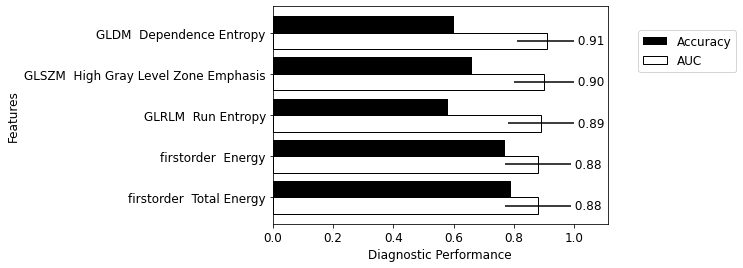

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
auc_5=pd.read_excel('/Users/mnlmd/Documents/PyradiomicsResults/20221223/20221223-135010/Original/GCA/Results/LGR_auc_top5.xlsx')

figurepath = "/Users/mnlmd/Documents/PyradiomicsResults/20221223/20221223-135010/LGR_auc_top5.jpg"
plotaccaucnew(auc_5,figurepath)

In [ ]:
import pandas as pd